# Importación .xlsx

In [250]:
import sys, pandas as pd, openpyxl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, EngFormatter
import seaborn as sns
import seaborn.objects as so
import numpy as np
import statsmodels.api as sm  # Para el modelo de regresión OLS

In [251]:
df = pd.read_excel('/Users/gonzalocamunez/Documents/IDE Folder/3. scraper_viviendas/git_scraper_y_análisis_viviendas/resultados_scraper.xlsx', engine='openpyxl')
df.columns

Index(['scraper num', 'orden inicial', 'url', 'id_anuncio', 'calle',
       'nombre_urba', 'ciudad', 'barrio', 'centro_periferia', 'zona',
       'subzona', 'distrito', 'id_centro_periferia', 'id_zona', 'id_subzona',
       'id_distrito', 'id_metros_cuadrados_rangos', 'precio_en_euros',
       'metros_cuadrados', 'planta', 'total_estancias', 'num_dormitorios',
       'num_aseos', 'tipo_inmueble', 'planta_rangos', 'planta_rangos_xl',
       'metros_cuadrados_rangos', 'metros_cuadrados_rangos_xl', 'tipo_planta',
       'nuevo_usado', 'exterior_interior_chalet', 'exterior_interior',
       'garaje', 'garaje_num', 'jardin', 'jardin_num', 'piscina',
       'piscina_num', 'terraza', 'terraza_num', 'trastero', 'trastero_num',
       'balcon', 'balcon_num', 'aire_acondicionado', 'aire_acondicionado_num',
       'calefaccion', 'calefaccion_num', 'ascensor', 'ascensor_num'],
      dtype='object')

# 1. Objetivos (`EDA`)

### Input (de qué partimos)
- El scraper nos ha dado un fichero excel (`resultados_scraper.xlsx`) el cual hemos procesado y limpiado en excel.
- Importamos librerías, tomamos `resultados_scraper.xlsx` lo pasamos a un DataFrame y lo preprocesamos hasta dejarlo listo para comenzar con el EDA.
### Output (qué vamos a hacer)
El objetivo es dejar nuestro df listo para el análisis y para ello:
   1) Crearemos todas las columnas de datos que necesitamos con los formatos y tipos de datos correctos y revisando que no haya valores nulos.
   2) Revisaremos la distribución y los outliers de nuestras variables numéricas para asegurar la integridad de los datos.
   3) Revisaremos las distintas agrupaciones por categoría y sus tamaños muestrales para definir el alcance máximo del análisis por segmentos y hasta dónde podemos llegar en él.
   4) Crearemos los objetos "subconjunto" de nuestros datos que utilizaremos para operar, graficar y sacar conclusiones.
   5) Exportaremos el df (`1.EDA.ipynb` →`df_preparado.parquet`) y los subconjuntos para la Fase 2 de `Visualización y Análisis`

In [252]:
df = pd.read_excel('/Users/gonzalocamunez/Documents/IDE Folder/3. scraper_viviendas/git_scraper_y_análisis_viviendas/resultados_scraper.xlsx', engine='openpyxl')
scraper_columns = ['scraper num', 'orden inicial', 'url','id_anuncio','calle', 'nombre_urba', 'ciudad']
df = df.drop(columns=scraper_columns)
df.columns

Index(['barrio', 'centro_periferia', 'zona', 'subzona', 'distrito',
       'id_centro_periferia', 'id_zona', 'id_subzona', 'id_distrito',
       'id_metros_cuadrados_rangos', 'precio_en_euros', 'metros_cuadrados',
       'planta', 'total_estancias', 'num_dormitorios', 'num_aseos',
       'tipo_inmueble', 'planta_rangos', 'planta_rangos_xl',
       'metros_cuadrados_rangos', 'metros_cuadrados_rangos_xl', 'tipo_planta',
       'nuevo_usado', 'exterior_interior_chalet', 'exterior_interior',
       'garaje', 'garaje_num', 'jardin', 'jardin_num', 'piscina',
       'piscina_num', 'terraza', 'terraza_num', 'trastero', 'trastero_num',
       'balcon', 'balcon_num', 'aire_acondicionado', 'aire_acondicionado_num',
       'calefaccion', 'calefaccion_num', 'ascensor', 'ascensor_num'],
      dtype='object')

# 2. IDA - Initial Data Analysis

## 2.0 Valores nulos

In [253]:
df.isna().sum().sum()

np.int64(0)

## ** 2.1 Añadir `precio_el_metro_cuadrado`

De cara a tener el precio en un formato comparable lo hacemos unitario dividiéndolo entre la extensión en metros cuadrados de cada vivienda/observación.

In [254]:
df['precio_el_metro_cuadrado'] = df['precio_en_euros'] / df['metros_cuadrados']
orden_distritos = (
    df.groupby("distrito")["precio_el_metro_cuadrado"]
    .median()
    .sort_values(ascending=False)
    .index
)
df.columns
cols = list(df.columns)
cols.remove("precio_el_metro_cuadrado")
idx = cols.index("metros_cuadrados")
cols.insert(idx + 1, "precio_el_metro_cuadrado")
df = df[cols]


## ** 2.2 Añadir `equip_cols_agg`

In [255]:
ascensor_col = ["ascensor"]
servicios_cols = ["garaje", "trastero"]
espacios_de_ocio_cols = ['jardin', 'piscina']
vistas_cols = ['balcon', 'terraza']
clima_cols = ['aire_acondicionado', 'calefaccion']


In [256]:
df['equip_servicios'] = df['garaje'] + ", " + df['trastero']
df['equip_espacios_de_ocio'] = df['jardin'] + ", " + df['piscina']
df['equip_vistas'] = df['balcon'] + ", " + df['terraza']
df['equip_clima'] = df['aire_acondicionado'] + ", " + df['calefaccion']

In [257]:
equip_cols_agg = ['equip_servicios', 'equip_espacios_de_ocio', 'equip_vistas', 'equip_clima']

## ** 2.3 Añadir `precio_en_euros_rangos`

In [258]:
# Crear la variable categórica `precio_en_euros_rangos`

## Percentiles para rangos
p10_precio_en_euros = df['precio_en_euros'].quantile(0.10)
p25_precio_en_euros = df['precio_en_euros'].quantile(0.25)
p75_precio_en_euros = df['precio_en_euros'].quantile(0.75)
p90_precio_en_euros = df['precio_en_euros'].quantile(0.90)

## Crear columna de variable
df['precio_en_euros_rangos'] = None
df.loc[df['precio_en_euros'] <= p10_precio_en_euros, 'precio_en_euros_rangos'] = '10% más barato (Percentil 10)'
df.loc[(df['precio_en_euros'] > p10_precio_en_euros) & (df['precio_en_euros'] <= p25_precio_en_euros), 'precio_en_euros_rangos'] = '15% barato-intermedio'
df.loc[(df['precio_en_euros'] > p25_precio_en_euros) & (df['precio_en_euros'] < p75_precio_en_euros), 'precio_en_euros_rangos'] = '50% central (IQR)'
df.loc[(df['precio_en_euros'] >= p75_precio_en_euros) & (df['precio_en_euros'] < p90_precio_en_euros), 'precio_en_euros_rangos'] = '15% caro-intermedio'
df.loc[df['precio_en_euros'] >= p90_precio_en_euros, 'precio_en_euros_rangos'] = '10% más caro (Percentil 90)'
orden_precio_en_euros_rangos = ['10% más barato (Percentil 10)','15% barato-intermedio','50% central (IQR)', '15% caro-intermedio','10% más caro (Percentil 90)']

## ** 2.4 Añadir `precio_el_metro_cuadrado_rangos`

In [259]:
# Crear la variable categórica `precio_el_metro_cuadrado_rangos`

## Percentiles para rangos
p10_precio_en_euros = df['precio_el_metro_cuadrado'].quantile(0.10)
p25_precio_en_euros = df['precio_el_metro_cuadrado'].quantile(0.25)
p75_precio_en_euros = df['precio_el_metro_cuadrado'].quantile(0.75)
p90_precio_en_euros = df['precio_el_metro_cuadrado'].quantile(0.90)

## Crear columna de variable
df['precio_el_metro_cuadrado_rangos'] = None
df.loc[df['precio_el_metro_cuadrado'] <= p10_precio_en_euros, 'precio_el_metro_cuadrado_rangos'] = '10% pmc más bajo (Percentil 10)'
df.loc[(df['precio_el_metro_cuadrado'] > p10_precio_en_euros) & (df['precio_el_metro_cuadrado'] <= p25_precio_en_euros), 'precio_el_metro_cuadrado_rangos'] = '15% pmc barato-intermedio'
df.loc[(df['precio_el_metro_cuadrado'] > p25_precio_en_euros) & (df['precio_el_metro_cuadrado'] < p75_precio_en_euros), 'precio_el_metro_cuadrado_rangos'] = '50% pmc central (IQR)'
df.loc[(df['precio_el_metro_cuadrado'] >= p75_precio_en_euros) & (df['precio_el_metro_cuadrado'] < p90_precio_en_euros), 'precio_el_metro_cuadrado_rangos'] = '15% pmc caro-intermedio'
df.loc[df['precio_el_metro_cuadrado'] >= p90_precio_en_euros, 'precio_el_metro_cuadrado_rangos'] = '10% pmc más alto (Percentil 90)'
precio_el_metro_cuadrado_rangos_orden = ['10% pmc más alto (Percentil 90)', '15% pmc caro-intermedio', '50% pmc central (IQR)', '15% pmc barato-intermedio', '10% pmc más bajo (Percentil 10)']

## 2.5 Columnado final

Tomamos el excel que resulta del scraper y le quitamos las columnas que no nos interesan. De las columnas que dejamos hacemos listados para utilizar distintos columnados para distintas cosas.

In [260]:
df.columns

Index(['barrio', 'centro_periferia', 'zona', 'subzona', 'distrito',
       'id_centro_periferia', 'id_zona', 'id_subzona', 'id_distrito',
       'id_metros_cuadrados_rangos', 'precio_en_euros', 'metros_cuadrados',
       'precio_el_metro_cuadrado', 'planta', 'total_estancias',
       'num_dormitorios', 'num_aseos', 'tipo_inmueble', 'planta_rangos',
       'planta_rangos_xl', 'metros_cuadrados_rangos',
       'metros_cuadrados_rangos_xl', 'tipo_planta', 'nuevo_usado',
       'exterior_interior_chalet', 'exterior_interior', 'garaje', 'garaje_num',
       'jardin', 'jardin_num', 'piscina', 'piscina_num', 'terraza',
       'terraza_num', 'trastero', 'trastero_num', 'balcon', 'balcon_num',
       'aire_acondicionado', 'aire_acondicionado_num', 'calefaccion',
       'calefaccion_num', 'ascensor', 'ascensor_num', 'equip_servicios',
       'equip_espacios_de_ocio', 'equip_vistas', 'equip_clima',
       'precio_en_euros_rangos', 'precio_el_metro_cuadrado_rangos'],
      dtype='object')

In [261]:
### Columnas por categoría de datos
location_cols = ['barrio', 'centro_periferia', 'zona', 'subzona', 'distrito']
id_cols = ['id_centro_periferia', 'id_zona', 'id_distrito', 'id_metros_cuadrados_rangos']
price_sqm_cols = ['precio_en_euros', 'metros_cuadrados', 'precio_el_metro_cuadrado']
planta_y_estancias_cols = ['planta', 'total_estancias', 'num_dormitorios', 'num_aseos']
categ_cols = ['tipo_inmueble', 'planta_rangos', 'planta_rangos_xl', 'metros_cuadrados_rangos', 'metros_cuadrados_rangos_xl', 'tipo_planta', 'nuevo_usado', 'exterior_interior_chalet', 'exterior_interior']
equip_cols = ['garaje', 'jardin', 'piscina', 'terraza', 'trastero', 'balcon', 'aire_acondicionado', 'calefaccion', 'ascensor']
equip_cols_num = ['garaje_num', 'jardin_num', 'piscina_num', 'terraza_num', 'trastero_num', 'balcon_num', 'aire_acondicionado_num', 'calefaccion_num', 'ascensor_num']
equip_cols_agg = ['equip_servicios', 'equip_espacios_de_ocio', 'equip_vistas', 'equip_clima']

data_cols = location_cols + price_sqm_cols + planta_y_estancias_cols + categ_cols + equip_cols

### Columnas por 'zona' y 'subzona'
zonas = (df.sort_values('id_zona')['zona'].drop_duplicates().to_numpy()).tolist()  # único y ordenado por id_zona
subzonas = (df.sort_values('id_subzona')['subzona'].drop_duplicates().to_numpy()).tolist()  # único y ordenado por id_zona

## 2.6 Tipos de datos

In [262]:
print(df.dtypes)

barrio                              object
centro_periferia                    object
zona                                object
subzona                             object
distrito                            object
id_centro_periferia                  int64
id_zona                              int64
id_subzona                         float64
id_distrito                          int64
id_metros_cuadrados_rangos           int64
precio_en_euros                      int64
metros_cuadrados                     int64
precio_el_metro_cuadrado           float64
planta                               int64
total_estancias                      int64
num_dormitorios                      int64
num_aseos                            int64
tipo_inmueble                       object
planta_rangos                       object
planta_rangos_xl                    object
metros_cuadrados_rangos             object
metros_cuadrados_rangos_xl          object
tipo_planta                         object
nuevo_usado

In [263]:
### Conversión de tipos de datos
df[location_cols] = df[location_cols].astype("string")
#df[id_cols] ya están formateadas correctamente
#df[price_sqm_cols] ya están formateadas correctamente
#df[planta_y_estancias_cols ] ya están formateadas correctamente
df[categ_cols] = df[categ_cols].astype("string")
df[equip_cols] = df[equip_cols].astype("string")
print(df.dtypes)

barrio                             string[python]
centro_periferia                   string[python]
zona                               string[python]
subzona                            string[python]
distrito                           string[python]
id_centro_periferia                         int64
id_zona                                     int64
id_subzona                                float64
id_distrito                                 int64
id_metros_cuadrados_rangos                  int64
precio_en_euros                             int64
metros_cuadrados                            int64
precio_el_metro_cuadrado                  float64
planta                                      int64
total_estancias                             int64
num_dormitorios                             int64
num_aseos                                   int64
tipo_inmueble                      string[python]
planta_rangos                      string[python]
planta_rangos_xl                   string[python]


## 2.7 Sumstats

El objetivo es tener una idea inicial de la estructura de nuestros datos. Para ello creamos primero `df_sumstats`:

In [264]:
df_sumstats = df.describe().copy()
df_sumstats

,id_centro_periferia,id_zona,id_subzona,id_distrito,id_metros_cuadrados_rangos,precio_en_euros,metros_cuadrados,precio_el_metro_cuadrado,planta,total_estancias,...,num_aseos,garaje_num,jardin_num,piscina_num,terraza_num,trastero_num,balcon_num,aire_acondicionado_num,calefaccion_num,ascensor_num
count,610.000000,610.000000,610.000000,610.000000,610.000000,6.100000e+02,610.000000,610.000000,610.000000,610.000000,...,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000
mean,1.401639,1.934426,2.077049,8.337705,305.500000,1.404921e+06,178.991803,7501.968350,2.675410,7.257377,...,2.290164,0.291803,0.178689,0.177049,0.355738,0.319672,0.231148,0.655738,0.718033,0.711475
std,0.490632,1.336231,1.239709,5.777829,176.236111,1.643467e+06,224.723165,3741.052235,2.327014,2.717272,...,1.251364,0.454965,0.383406,0.382024,0.479129,0.466732,0.421913,0.475517,0.450327,0.453448
min,1.000000,1.000000,1.100000,1.000000,1.000000,9.900000e+04,20.000000,1345.000000,-1.000000,3.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.200000,4.000000,153.250000,3.499925e+05,70.000000,4527.740144,1.000000,5.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.300000,5.000000,305.500000,7.650000e+05,109.500000,6726.063830,2.000000,7.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,2.000000,3.000000,3.000000,13.000000,457.750000,1.696750e+06,198.750000,9980.158730,4.000000,8.000000,...,3.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,2.000000,5.000000,5.000000,21.000000,610.000000,9.250000e+06,3015.000000,22560.975610,16.000000,19.000000,...,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Definimos las columas relevantes a las que tiene sentido calcular estadísticos:

In [265]:
sumstat_cols = price_sqm_cols + planta_y_estancias_cols
df_sumstats_compact = df_sumstats[sumstat_cols].copy()
df_sumstats_compact

,precio_en_euros,metros_cuadrados,precio_el_metro_cuadrado,planta,total_estancias,num_dormitorios,num_aseos
count,6.100000e+02,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000
mean,1.404921e+06,178.991803,7501.968350,2.675410,7.257377,2.967213,2.290164
std,1.643467e+06,224.723165,3741.052235,2.327014,2.717272,1.634674,1.251364
min,9.900000e+04,20.000000,1345.000000,-1.000000,3.000000,0.000000,1.000000
25%,3.499925e+05,70.000000,4527.740144,1.000000,5.000000,2.000000,1.000000
50%,7.650000e+05,109.500000,6726.063830,2.000000,7.000000,3.000000,2.000000
75%,1.696750e+06,198.750000,9980.158730,4.000000,8.000000,4.000000,3.000000
max,9.250000e+06,3015.000000,22560.975610,16.000000,19.000000,13.000000,5.000000


Añadimos `min/mean` y `max/mean`, dos medidas de cuánto se alejan los mínimos y los máximos del valor central, en este caso la media (`mean`):

In [266]:
df_sumstats_compact.loc["max/mean"] = df_sumstats_compact.loc["max"] / df_sumstats_compact.loc["mean"]
df_sumstats_compact.loc["min/mean"] = df_sumstats_compact.loc["min"] / df_sumstats_compact.loc["mean"]
df_sumstats_compact


,precio_en_euros,metros_cuadrados,precio_el_metro_cuadrado,planta,total_estancias,num_dormitorios,num_aseos
count,6.100000e+02,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000
mean,1.404921e+06,178.991803,7501.968350,2.675410,7.257377,2.967213,2.290164
std,1.643467e+06,224.723165,3741.052235,2.327014,2.717272,1.634674,1.251364
min,9.900000e+04,20.000000,1345.000000,-1.000000,3.000000,0.000000,1.000000
25%,3.499925e+05,70.000000,4527.740144,1.000000,5.000000,2.000000,1.000000
50%,7.650000e+05,109.500000,6726.063830,2.000000,7.000000,3.000000,2.000000
75%,1.696750e+06,198.750000,9980.158730,4.000000,8.000000,4.000000,3.000000
max,9.250000e+06,3015.000000,22560.975610,16.000000,19.000000,13.000000,5.000000
max/mean,6.584002e+00,16.844347,3.007341,5.980392,2.618026,4.381215,2.183250
min/mean,7.046661e-02,0.111737,0.179286,-0.373775,0.413372,0.000000,0.436650


Observamos que los valores con más desviación de sus **valores extremos** son:

1. `metros_cuadrados` : mean = 178.991803   → max = 16.8... veces la media     |   
2. `precio_en_euros`  : mean = 1.404921e+06 → max = 6.5...  veces la media     |    min = 7.04...  veces la media.
3. El resto o son correctos (`precio_el_metro_cuadrado`) o se pueden considerar variables categóricas.

# 3. Outliers

## 3.1 `precio_en_euros`

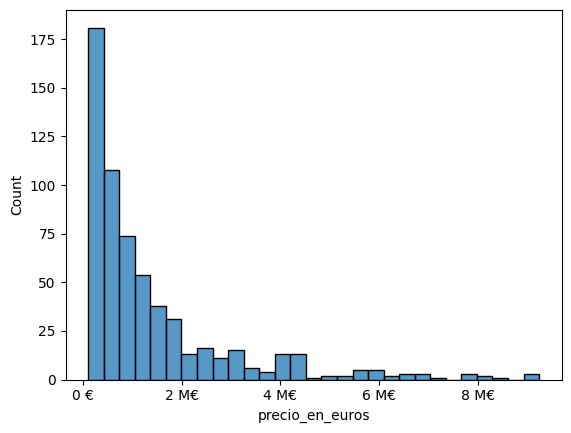

In [267]:
ax = sns.histplot(data=df, x="precio_en_euros")
ax.xaxis.set_major_formatter(EngFormatter(unit='€', places=0))

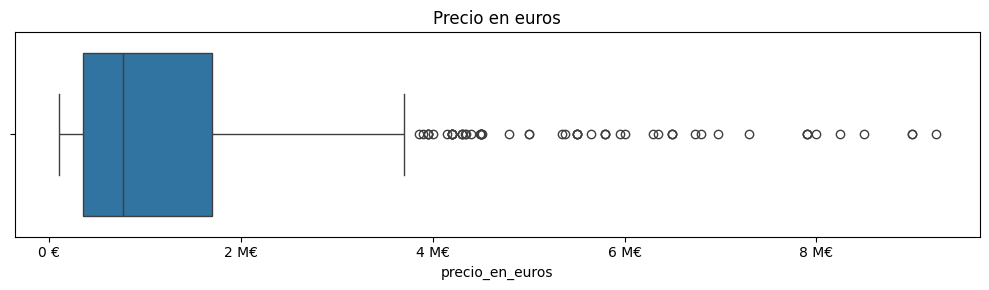

In [268]:
plt.figure(figsize=(10, 3))
ax = sns.boxplot(x=df['precio_en_euros'], orient='h')
ax.xaxis.set_major_formatter(EngFormatter(unit='€', places=0))
plt.title('Precio en euros')
plt.tight_layout()
plt.show()

In [269]:
# Para una columna específica
Q1_precio_en_euros = df['precio_en_euros'].quantile(0.25)
Q3_precio_en_euros = df['precio_en_euros'].quantile(0.75)
IQR_precio_en_euros = Q3_precio_en_euros - Q1_precio_en_euros

# Detectar outliers
outliers_precio_en_euros = (df['precio_en_euros'] < Q1_precio_en_euros - 3*IQR_precio_en_euros) | (df['precio_en_euros'] > Q3_precio_en_euros + 3*IQR_precio_en_euros)
filas_outliers_precio_en_euros = df[outliers_precio_en_euros].index
df_outliers_precio_en_euros = df.loc[filas_outliers_precio_en_euros]
df_outliers_precio_en_euros = df_outliers_precio_en_euros.sort_values(by='precio_en_euros', ascending=False)
num_outliers = outliers_precio_en_euros.sum()
print(num_outliers)
df_outliers_precio_en_euros[location_cols + price_sqm_cols + planta_y_estancias_cols]

23


,barrio,centro_periferia,zona,subzona,distrito,precio_en_euros,metros_cuadrados,precio_el_metro_cuadrado,planta,total_estancias,num_dormitorios,num_aseos
564,Jerónimos,centro,centro,centro-sur,Retiro,9250000,410,22560.975610,2,11,4,5
608,El Plantío,periferia,oeste,oeste,Moncloa,9000000,1674,5376.344086,0,16,9,5
607,El Plantío,periferia,oeste,oeste,Moncloa,9000000,1674,5376.344086,0,16,9,5
570,Recoletos,centro,centro,centro-medio,Barrio de Salamanca,8500000,460,18478.260870,1,11,5,4
609,Ciudad Universitaria,periferia,oeste,oeste,Moncloa,8250000,3015,2736.318408,0,17,10,5
580,Castellana,centro,centro,centro-medio,Barrio de Salamanca,8000000,510,15686.274510,5,9,3,4
574,Castellana,centro,centro,centro-medio,Barrio de Salamanca,7900000,473,16701.902748,2,11,4,5
561,Recoletos,centro,centro,centro-medio,Barrio de Salamanca,7900000,407,19410.319410,6,11,5,4
573,Castellana,centro,centro,centro-medio,Barrio de Salamanca,7900000,473,16701.902748,2,11,4,5
578,Almagro,centro,centro,centro-medio,Chamberí,7300000,505,14455.445545,4,14,7,5


In [270]:
df_sin_outliers_precio_en_euros = df.drop(df_outliers_precio_en_euros.index)

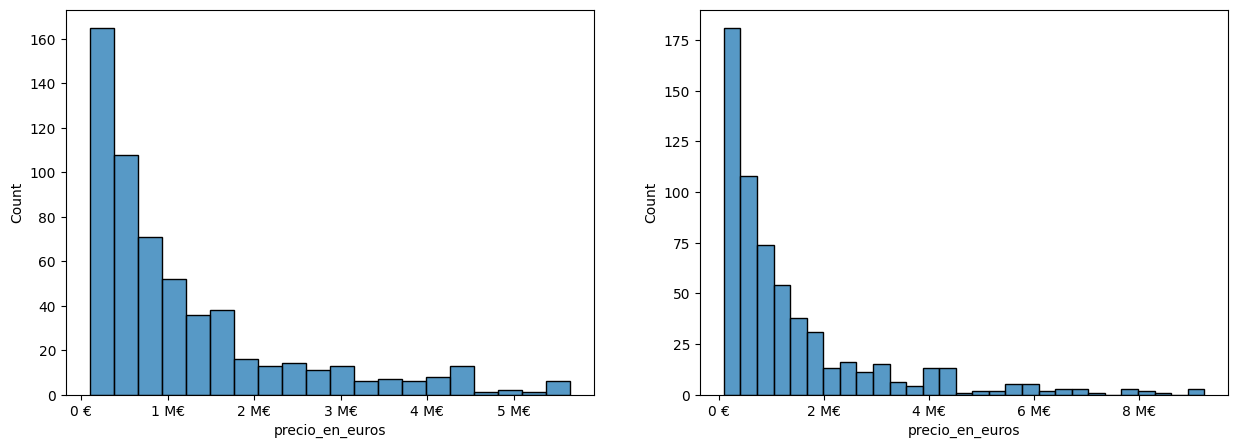

In [271]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df_sin_outliers_precio_en_euros, x="precio_en_euros", ax=axes[0])
sns.histplot(data=df,ax=axes[1], x="precio_en_euros")

axes[0].xaxis.set_major_formatter(EngFormatter(unit='€', places=0))
axes[1].xaxis.set_major_formatter(EngFormatter(unit='€', places=0))

### 3.1.2 `precio_en_euros` (pisos)

In [272]:
df_pisos = df[df['tipo_inmueble'] == 'piso']

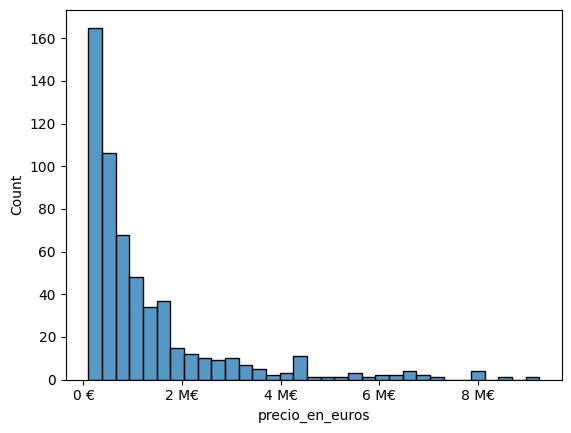

In [273]:
ax = sns.histplot(data=df_pisos, x="precio_en_euros")
ax.xaxis.set_major_formatter(EngFormatter(unit='€', places=0))

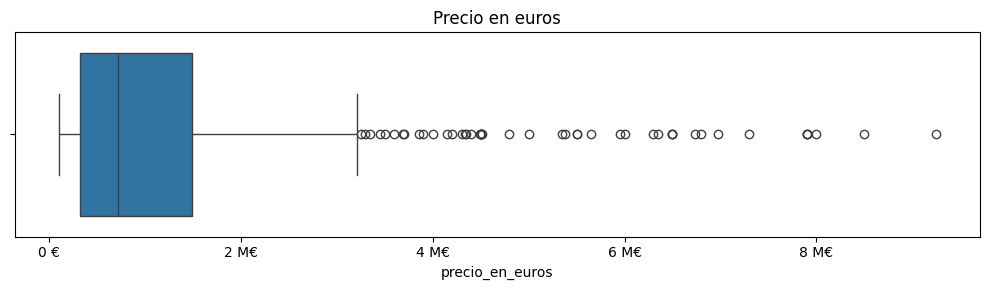

In [274]:
plt.figure(figsize=(10, 3))
ax = sns.boxplot(x=df_pisos['precio_en_euros'], orient='h')
ax.xaxis.set_major_formatter(EngFormatter(unit='€', places=0))
plt.title('Precio en euros')
plt.tight_layout()
plt.show()

In [275]:
# Para una columna específica
Q1_precio_en_euros_pisos = df_pisos['precio_en_euros'].quantile(0.25)
Q3_precio_en_euros_pisos = df_pisos['precio_en_euros'].quantile(0.75)
IQR_precio_en_euros_pisos = Q3_precio_en_euros_pisos - Q1_precio_en_euros_pisos

# Detectar outliers
outliers_precio_en_euros_pisos = (df_pisos['precio_en_euros'] < Q1_precio_en_euros_pisos - 3*IQR_precio_en_euros_pisos) | (df_pisos['precio_en_euros'] > Q3_precio_en_euros_pisos + 3*IQR_precio_en_euros_pisos)
filas_pisos_outliers_precio_en_euros = df_pisos[outliers_precio_en_euros_pisos].index
df_pisos_outliers_precio_en_euros = df_pisos.loc[filas_pisos_outliers_precio_en_euros]
df_pisos_outliers_precio_en_euros = df_pisos_outliers_precio_en_euros.sort_values(by='precio_en_euros', ascending=False)
num_outliers = outliers_precio_en_euros_pisos.sum()
print(num_outliers)
df_pisos_outliers_precio_en_euros[location_cols + price_sqm_cols + planta_y_estancias_cols]

22


,barrio,centro_periferia,zona,subzona,distrito,precio_en_euros,metros_cuadrados,precio_el_metro_cuadrado,planta,total_estancias,num_dormitorios,num_aseos
564,Jerónimos,centro,centro,centro-sur,Retiro,9250000,410,22560.975610,2,11,4,5
570,Recoletos,centro,centro,centro-medio,Barrio de Salamanca,8500000,460,18478.260870,1,11,5,4
580,Castellana,centro,centro,centro-medio,Barrio de Salamanca,8000000,510,15686.274510,5,9,3,4
561,Recoletos,centro,centro,centro-medio,Barrio de Salamanca,7900000,407,19410.319410,6,11,5,4
574,Castellana,centro,centro,centro-medio,Barrio de Salamanca,7900000,473,16701.902748,2,11,4,5
573,Castellana,centro,centro,centro-medio,Barrio de Salamanca,7900000,473,16701.902748,2,11,4,5
578,Almagro,centro,centro,centro-medio,Chamberí,7300000,505,14455.445545,4,14,7,5
575,Recoletos,centro,centro,centro-medio,Barrio de Salamanca,6980000,480,14541.666667,6,11,4,5
576,Recoletos,centro,centro,centro-medio,Barrio de Salamanca,6800000,490,13877.551020,2,12,5,5
541,Almagro,centro,centro,centro-medio,Chamberí,6730000,345,19507.246377,5,10,4,4


In [276]:
df_pisos_sin_outliers_precio_en_euros = df_pisos.drop(df_pisos_outliers_precio_en_euros.index)

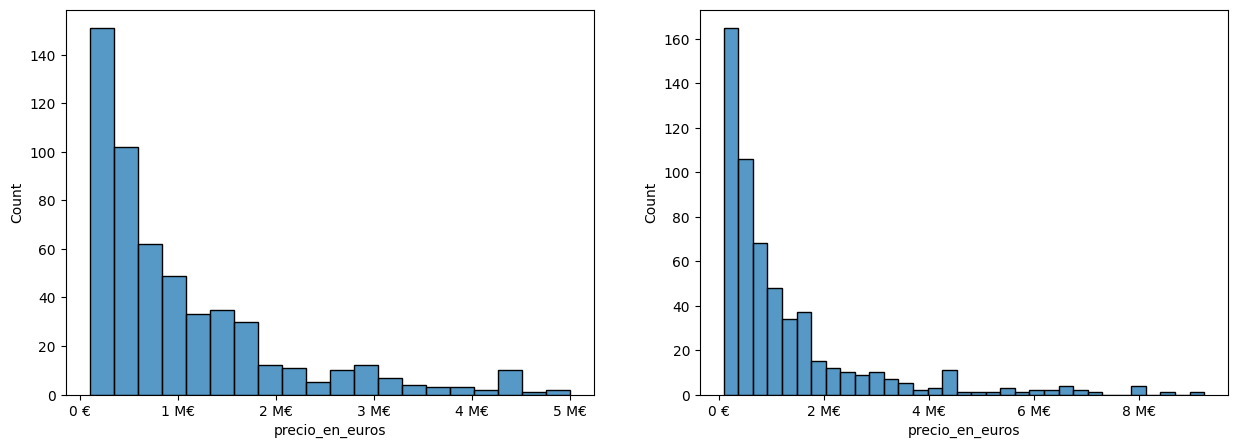

In [277]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df_pisos_sin_outliers_precio_en_euros, x="precio_en_euros", ax=axes[0])
sns.histplot(data=df_pisos,ax=axes[1], x="precio_en_euros")

axes[0].xaxis.set_major_formatter(EngFormatter(unit='€', places=0))
axes[1].xaxis.set_major_formatter(EngFormatter(unit='€', places=0))

### ** 3.1.3 Añadir `precio_en_euros_rangos`

Como vimos anteriormente, los outliers de `precio_en_euros` se encuentran repartidos de forma razonablemente equitativa entre ambos tipos de inmuebles:

tipo_inmueble
Piso      17
chalet     6

Por este motivo crearemos una nueva variable `precio_en_euros_rangos` que agrupará los valores de `precio_en_euros` en todo el dataset (df).

In [278]:
# El precio_en_euros es, en muy buena medida, una variable categórica en si misma puesto que un precio más alto en términos absolutos puede considerarse una característica del piso.
# Un inmueble de mayor precio absoluto (precio_en_euros) puede serlo por muchos motivos diferentes y es importante entender por cuales analizando el cruce de `precio_en_euros` con otras categorías.
# Para poder hacerlo, transformamos el precio_en_euros en una variable categórica mediante rangos primero para lo cual usaremos estadística descriptiva básica:

# Cálculo de percentiles
p10_precio_en_euros = df['precio_en_euros'].quantile(0.10)
p25_precio_en_euros = df['precio_en_euros'].quantile(0.25)
p75_precio_en_euros = df['precio_en_euros'].quantile(0.75)
p90_precio_en_euros = df['precio_en_euros'].quantile(0.90)

# Crear la variable categórica
df['precio_en_euros_rangos'] = None
df.loc[df['precio_en_euros'] <= p10_precio_en_euros, 'precio_en_euros_rangos'] = '10% más barato (Percentil 10)'
df.loc[(df['precio_en_euros'] > p10_precio_en_euros) & (df['precio_en_euros'] <= p25_precio_en_euros), 'precio_en_euros_rangos'] = '15% barato-intermedio'
df.loc[(df['precio_en_euros'] > p25_precio_en_euros) & (df['precio_en_euros'] < p75_precio_en_euros), 'precio_en_euros_rangos'] = '50% central (IQR)'
df.loc[(df['precio_en_euros'] >= p75_precio_en_euros) & (df['precio_en_euros'] < p90_precio_en_euros), 'precio_en_euros_rangos'] = '15% caro-intermedio'
df.loc[df['precio_en_euros'] >= p90_precio_en_euros, 'precio_en_euros_rangos'] = '10% más caro (Percentil 90)'

# Verificar distribución
print(df['precio_en_euros_rangos'].value_counts(normalize=True).sort_index())

precio_en_euros_rangos
10% más barato (Percentil 10)    0.103279
10% más caro (Percentil 90)      0.100000
15% barato-intermedio            0.147541
15% caro-intermedio              0.150820
50% central (IQR)                0.498361
Name: proportion, dtype: float64


In [279]:
df['precio_en_euros_rangos'].shape

(610,)

In [280]:
df['precio_en_euros_rangos'].value_counts()

precio_en_euros_rangos
50% central (IQR)                304
15% caro-intermedio               92
15% barato-intermedio             90
10% más barato (Percentil 10)     63
10% más caro (Percentil 90)       61
Name: count, dtype: int64

## 3.2 `precio_el_metro_cuadrado`

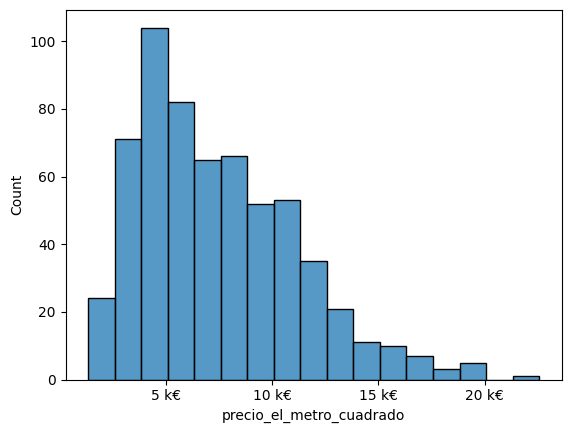

In [281]:
ax = sns.histplot(data=df, x="precio_el_metro_cuadrado")
ax.xaxis.set_major_formatter(EngFormatter(unit='€', places=0))

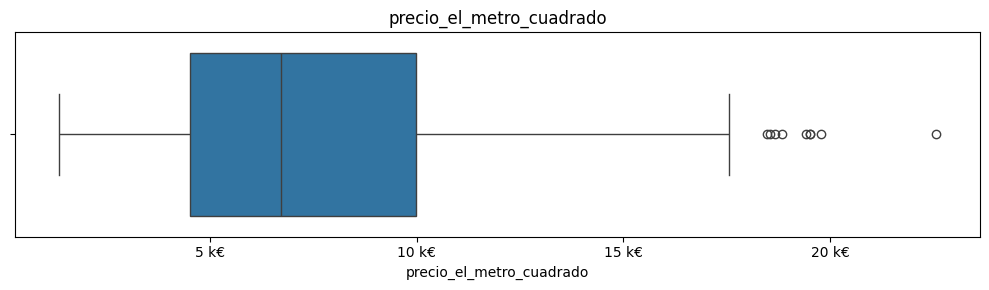

In [282]:
plt.figure(figsize=(10, 3))
ax = sns.boxplot(x=df['precio_el_metro_cuadrado'], orient='h')
ax.xaxis.set_major_formatter(EngFormatter(unit='€', places=0))
plt.title('precio_el_metro_cuadrado')
plt.tight_layout()
plt.show()

In [283]:
# Para una columna específica
Q1_precio_el_metro_cuadrado = df['precio_el_metro_cuadrado'].quantile(0.25)
Q3_precio_el_metro_cuadrado = df['precio_el_metro_cuadrado'].quantile(0.75)
IQR_precio_el_metro_cuadrado = Q3_precio_el_metro_cuadrado - Q1_precio_el_metro_cuadrado

# Detectar outliers
outliers_precio_el_metro_cuadrado = (df['precio_el_metro_cuadrado'] < Q1_precio_el_metro_cuadrado - 2*IQR_precio_el_metro_cuadrado) | (df['precio_el_metro_cuadrado'] > Q3_precio_el_metro_cuadrado + 2*IQR_precio_el_metro_cuadrado)
filas_outliers_precio_el_metro_cuadrado = df[outliers_precio_el_metro_cuadrado].index
df_outliers_precio_el_metro_cuadrado = df.loc[filas_outliers_precio_el_metro_cuadrado]
df_outliers_precio_el_metro_cuadrado = df_outliers_precio_el_metro_cuadrado.sort_values(by='precio_el_metro_cuadrado', ascending=False)
num_outliers = outliers_precio_el_metro_cuadrado.sum()
print(num_outliers)
df_outliers_precio_el_metro_cuadrado[location_cols + price_sqm_cols + planta_y_estancias_cols]

1


,barrio,centro_periferia,zona,subzona,distrito,precio_en_euros,metros_cuadrados,precio_el_metro_cuadrado,planta,total_estancias,num_dormitorios,num_aseos
564,Jerónimos,centro,centro,centro-sur,Retiro,9250000,410,22560.97561,2,11,4,5


In [284]:
df_sin_outliers_precio_el_metro_cuadrado = df.drop(df_outliers_precio_el_metro_cuadrado.index)

<Axes: xlabel='precio_el_metro_cuadrado', ylabel='Count'>

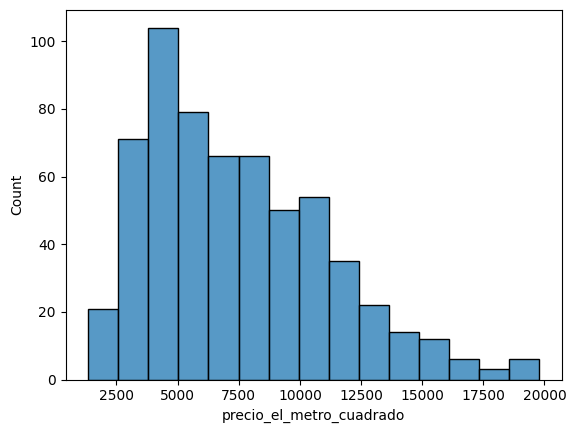

In [285]:
sns.histplot(data=df_sin_outliers_precio_el_metro_cuadrado, x="precio_el_metro_cuadrado")

## 3.3 `metros_cuadrados`

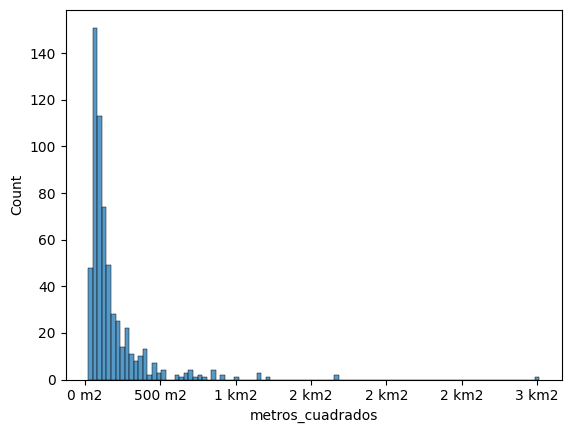

In [286]:
ax = sns.histplot(data=df, x="metros_cuadrados")
ax.xaxis.set_major_formatter(EngFormatter(unit='m2', places=0))

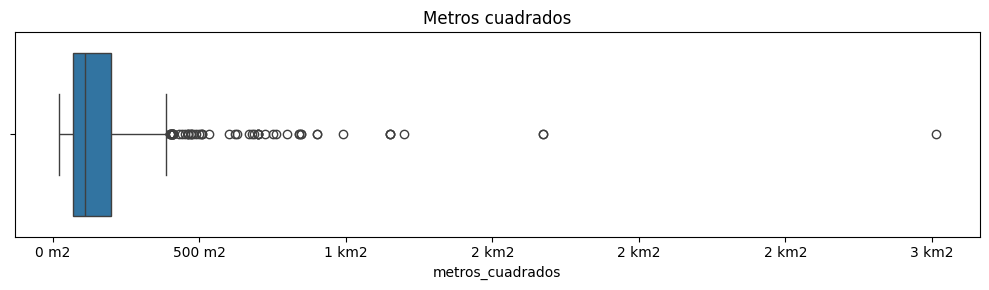

In [287]:
plt.figure(figsize=(10, 3))
ax = sns.boxplot(x=df['metros_cuadrados'], orient='h')
ax.xaxis.set_major_formatter(EngFormatter(unit='m2', places=0))
plt.title('Metros cuadrados')
plt.tight_layout()
plt.show()

### *** df_sin_outliers_metros_cuadrados

Los outliers son observaciones que queremos mantener para nuestro análisis ya que no se tratan de errores si no de viviendas de gran tamaño de dos tipos (revisar `df_outliers_metros_cuadrados`):
  - Pisos de gran tamaño en la zona centro y más concretamente en Salamanca.
  - Casas de grandes dimensiones en las periferia oeste, algunas con grandes espacios exteriores.

Por este motivo, para algunas visualizaciones que impliquen específicamente la variable `metros_cuadrados`, proporcionaremos dos vistas separadas: una primera que los incluyan y otra segunda que los excluyan, con el fin de tener la imagen más precisa posible.

Haremos lo mismo con el df que incluye exclusivamente pisos (`df_pisos`) que vamos a usar muy a menudo cuando queramos centrar nuestro análisis en este tipo de vivienda.

In [288]:
# Para una columna específica
Q1_metros_cuadrados = df['metros_cuadrados'].quantile(0.25)
Q3_metros_cuadrados = df['metros_cuadrados'].quantile(0.75)
IQR_metros_cuadrados = Q3_metros_cuadrados - Q1_metros_cuadrados

# Detectar outliers
outliers_metros_cuadrados = (df['metros_cuadrados'] < Q1_metros_cuadrados - 3*IQR_metros_cuadrados) | (df['metros_cuadrados'] > Q3_metros_cuadrados + 3*IQR_metros_cuadrados)
filas_outliers_metros_cuadrados = df[outliers_metros_cuadrados].index
df_outliers_metros_cuadrados = df.loc[filas_outliers_metros_cuadrados]
df_outliers_metros_cuadrados =df_outliers_metros_cuadrados.sort_values(by='metros_cuadrados', ascending=True)
num_outliers = outliers_metros_cuadrados.sum()
print(num_outliers)


28


In [289]:
df_outliers_metros_cuadrados[location_cols + price_sqm_cols + planta_y_estancias_cols]

,barrio,centro_periferia,zona,subzona,distrito,precio_en_euros,metros_cuadrados,precio_el_metro_cuadrado,planta,total_estancias,num_dormitorios,num_aseos
582,Peñagrande,periferia,norte,norte,Fuencarral,1240000,601,2063.227953,0,16,9,5
583,Almagro,centro,centro,centro-medio,Chamberí,4800000,620,7741.935484,6,13,6,5
584,El Plantío,periferia,oeste,oeste,Moncloa,3500000,630,5555.555556,0,13,6,5
585,Almagro,centro,centro,centro-medio,Chamberí,6350000,670,9477.611940,5,12,5,5
586,Valdemarín,periferia,oeste,oeste,Moncloa,4300000,681,6314.243759,0,19,13,4
587,Valdemarín,periferia,oeste,oeste,Moncloa,2500000,685,3649.635036,0,18,11,5
588,El Plantío,periferia,oeste,oeste,Moncloa,4200000,700,6000.000000,0,13,6,5
589,El Plantío,periferia,oeste,oeste,Moncloa,4200000,700,6000.000000,0,13,6,5
590,El Plantío,periferia,oeste,oeste,Moncloa,4200000,700,6000.000000,0,13,6,5
591,El Plantío,periferia,oeste,oeste,Moncloa,2800000,700,4000.000000,0,13,6,5


In [290]:
df_sin_outliers_metros_cuadrados = df.drop(df_outliers_metros_cuadrados.index)

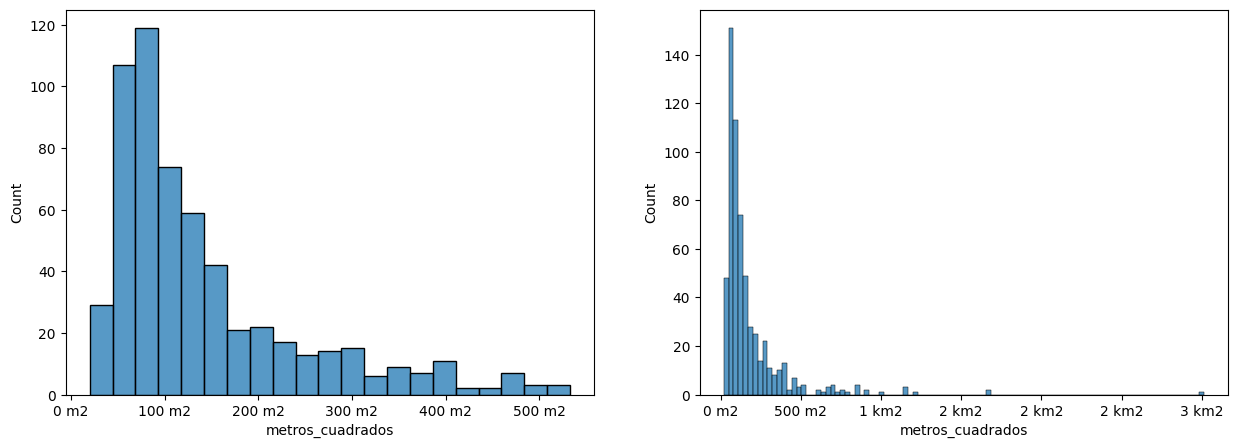

In [291]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=df_sin_outliers_metros_cuadrados, x="metros_cuadrados", ax=axes[0])
axes[0].xaxis.set_major_formatter(EngFormatter(unit='m2', places=0))
sns.histplot(data=df, x="metros_cuadrados", ax=axes[1])
axes[1].xaxis.set_major_formatter(EngFormatter(unit='m2', places=0))

### *** df_pisos_sin_outliers_metros_cuadrados

In [292]:
# Para una columna específica
Q1_metros_cuadrados = df_pisos['metros_cuadrados'].quantile(0.25)
Q3_metros_cuadrados = df_pisos['metros_cuadrados'].quantile(0.75)
IQR_metros_cuadrados = Q3_metros_cuadrados - Q1_metros_cuadrados

# Detectar outliers
outliers_pisos_metros_cuadrados = (df_pisos['metros_cuadrados'] < Q1_metros_cuadrados - 3*IQR_metros_cuadrados) | (df_pisos['metros_cuadrados'] > Q3_metros_cuadrados + 3*IQR_metros_cuadrados)
filas_pisos_outliers_metros_cuadrados = df_pisos[outliers_pisos_metros_cuadrados].index
df_pisos_outliers_metros_cuadrados = df_pisos.loc[filas_pisos_outliers_metros_cuadrados]
df_pisos_outliers_metros_cuadrados =df_pisos_outliers_metros_cuadrados.sort_values(by='metros_cuadrados', ascending=True)
num_outliers = outliers_pisos_metros_cuadrados.sum()
print(num_outliers)


13


In [293]:
df_pisos_sin_outliers_metros_cuadrados = df_pisos.drop(df_pisos_outliers_metros_cuadrados.index)

## 3.4 `total_estancias`

<Axes: xlabel='total_estancias', ylabel='Count'>

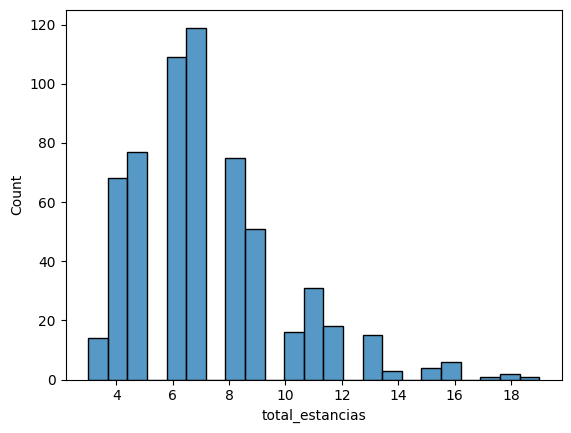

In [294]:
sns.histplot(data=df, x="total_estancias")

In [295]:
# Para una columna específica
Q1_total_estancias = df['total_estancias'].quantile(0.25)
Q3_total_estancias = df['total_estancias'].quantile(0.75)
IQR_total_estancias = Q3_total_estancias - Q1_total_estancias

# Detectar outliers
outliers_total_estancias = (df['total_estancias'] < Q1_total_estancias - 3*IQR_total_estancias) | (df['total_estancias'] > Q3_total_estancias + 3*IQR_total_estancias)
filas_outliers_total_estancias = df[outliers_total_estancias].index
df_outliers_total_estancias = df.loc[filas_outliers_total_estancias]
df_outliers_total_estancias =df_outliers_total_estancias.sort_values(by='total_estancias', ascending=True)
num_outliers_total_estancias = outliers_total_estancias.sum()
print(num_outliers_total_estancias)

3


In [296]:
df_outliers_total_estancias[location_cols + price_sqm_cols + planta_y_estancias_cols]

,barrio,centro_periferia,zona,subzona,distrito,precio_en_euros,metros_cuadrados,precio_el_metro_cuadrado,planta,total_estancias,num_dormitorios,num_aseos
587,Valdemarín,periferia,oeste,oeste,Moncloa,2500000,685,3649.635036,0,18,11,5
594,Valdemarín,periferia,oeste,oeste,Moncloa,2500000,761,3285.151117,0,18,11,5
586,Valdemarín,periferia,oeste,oeste,Moncloa,4300000,681,6314.243759,0,19,13,4


In [297]:
df_sin_outliers_total_estancias = df.drop(df_outliers_total_estancias.index)

<Axes: xlabel='total_estancias', ylabel='Count'>

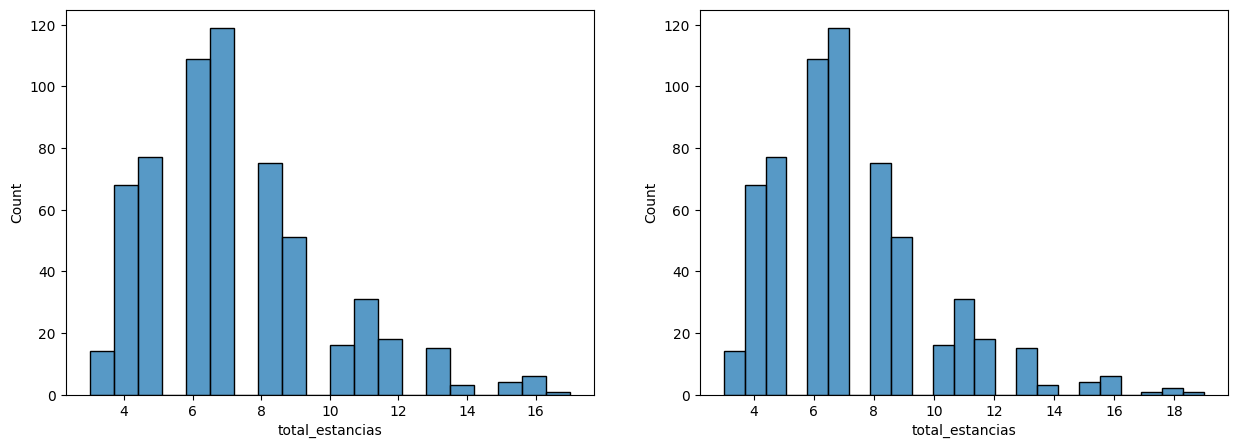

In [298]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df_sin_outliers_total_estancias, x="total_estancias", ax=axes[0])
sns.histplot(data=df, x="total_estancias", ax=axes[1])

# 4. Categorías

Hay que ver que cantidad de observaciones tenemos para cada categoría para ver hasta que punto podemos hacer agrupaciones de observaciones en base a categorías (segmentos). Es conveniente tener al menos 50 observaciones de cada categoría. Esta cifra será nuestra referencia de mínimos, lo que quiere decir que:
   1) Si estamos por encima de esta cifra podemos hablar de el segmento con suficiente confianza.
   2) Si estamos por debajo de esta cifra tendremos que analizar las observaciones (numéricamente y utilizando la lógica) para sacar conclusiones y en base a ese análisis concluir el grado de confianza de nuestras conclusiones.

## 4.1 Segmentables

In [299]:
df[['centro_periferia']].value_counts()

centro_periferia
centro              365
periferia           245
Name: count, dtype: int64

In [300]:
df[['zona']].value_counts()

zona  
centro    365
sur        72
este       69
oeste      56
norte      48
Name: count, dtype: int64

In [301]:
df[['metros_cuadrados_rangos']].value_counts()

metros_cuadrados_rangos
76-100                     96
61-75                      87
35-60                      77
121-150                    70
101-120                    60
151-200                    55
301-500                    49
201-250                    36
501<                       32
251-300                    30
0-35                       18
Name: count, dtype: int64

In [302]:
df[equip_cols_num].head()

,garaje_num,jardin_num,piscina_num,terraza_num,trastero_num,balcon_num,aire_acondicionado_num,calefaccion_num,ascensor_num
0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,1,1,0
2,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,1,1,0
4,0,0,0,0,0,0,1,1,0


In [303]:
df_counts = pd.DataFrame([
    {'variable': col, '0': (df[col] == 0).sum(), '1': (df[col] == 1).sum()}
    for col in equip_cols_num
])
df_counts

,variable,0,1
0,garaje_num,432,178
1,jardin_num,501,109
2,piscina_num,502,108
3,terraza_num,393,217
4,trastero_num,415,195
5,balcon_num,469,141
6,aire_acondicionado_num,210,400
7,calefaccion_num,172,438
8,ascensor_num,176,434


## 4.2 No segmentables

In [304]:
df['subzona'].value_counts()

subzona
centro-medio     165
centro-centro    101
sur               72
este              69
oeste             56
centro-norte      53
norte             48
centro-sur        46
Name: count, dtype: Int64

In [305]:
df['tipo_inmueble'].value_counts()

tipo_inmueble
piso      566
chalet     44
Name: count, dtype: Int64

## 4.3 Con muestras pequeñas

In [306]:
df['planta_rangos'].value_counts()

planta_rangos
1º                105
3º                103
2º                 99
4º                 70
0 (Bajo)           67
5º                 50
6º o 7º            48
0 (Chalet)         44
8º o más           20
-1 Semi-sótano      4
Name: count, dtype: Int64

In [307]:
df['nuevo_usado'].value_counts()

nuevo_usado
obra_usada       499
para_reformar     86
obra_nueva        25
Name: count, dtype: Int64

## 4.4 Conclusiones

1) `nuevo_usado` tiene casi todas las observaciones concentradas en `usado` y no conviene ir más allá de describir las proporciones entre las 3 subcategorías. En concreto [`nuevo_usado`] == `obra nueva` tiene muy poca muestra.
2) `tipo_inmueble` tiene casi todas las observaciones `piso`y tiene apenas observaciones en [`tipo_inmueble`] == `Chalet`.
3) `zona` tiene muestra suficiente en todas las categorías. Esta categorización por zonas es la más conocida para el público en general y por tanto es relevante a pesar de tener una muestra desigual:
    - [`zona`] == `centro` tiene la mayor muestra.
    - El resto de zonas tienen muestra suficiente (al menos 50 obervaciones o muy cerca de 50) y similar entre ellas pero cada una ellas mucho menor que [`zona`] == `centro`.
4) `subzona` tiene una muestra suficiente para todas las subzonas y mejor re


# 5. SUBCONJUNTOS

## 5.0 DataFrames de Outliers

In [308]:
# Outliers precio_en_euros
Q1_precio_en_euros = df['precio_en_euros'].quantile(0.25)
Q3_precio_en_euros = df['precio_en_euros'].quantile(0.75)
IQR_precio_en_euros = Q3_precio_en_euros - Q1_precio_en_euros

outliers_precio_en_euros = (df['precio_en_euros'] < Q1_precio_en_euros - 2*IQR_precio_en_euros) | (df['precio_en_euros'] > Q3_precio_en_euros + 2*IQR_precio_en_euros)
filas_outliers_precio_en_euros = df[outliers_precio_en_euros].index
df_outliers_precio_en_euros = df.loc[filas_outliers_precio_en_euros]
df_outliers_precio_en_euros = df_outliers_precio_en_euros.sort_values(by='precio_en_euros', ascending=False)

df_sin_outliers_precio_en_euros = df.drop(df_outliers_precio_en_euros.index)

# Outliers precio_el_metro_cuadrado
Q1_precio_el_metro_cuadrado = df['precio_el_metro_cuadrado'].quantile(0.25)
Q3_precio_el_metro_cuadrado = df['precio_el_metro_cuadrado'].quantile(0.75)
IQR_precio_el_metro_cuadrado = Q3_precio_el_metro_cuadrado - Q1_precio_el_metro_cuadrado

outliers_precio_el_metro_cuadrado = (df['precio_el_metro_cuadrado'] < Q1_precio_el_metro_cuadrado - 2*IQR_precio_el_metro_cuadrado) | (df['precio_el_metro_cuadrado'] > Q3_precio_el_metro_cuadrado + 2*IQR_precio_el_metro_cuadrado)
filas_outliers_precio_el_metro_cuadrado = df[outliers_precio_el_metro_cuadrado].index
df_outliers_precio_el_metro_cuadrado = df.loc[filas_outliers_precio_el_metro_cuadrado]
df_outliers_precio_el_metro_cuadrado = df_outliers_precio_el_metro_cuadrado.sort_values(by='precio_el_metro_cuadrado', ascending=True)

df_sin_outliers_precio_el_metro_cuadrado = df.drop(df_outliers_precio_el_metro_cuadrado.index)

# Outliers metros_cuadrados
Q1_metros_cuadrados = df['metros_cuadrados'].quantile(0.25)
Q3_metros_cuadrados = df['metros_cuadrados'].quantile(0.75)
IQR_metros_cuadrados = Q3_metros_cuadrados - Q1_metros_cuadrados

outliers_metros_cuadrados = (df['metros_cuadrados'] < Q1_metros_cuadrados - 2*IQR_metros_cuadrados) | (df['metros_cuadrados'] > Q3_metros_cuadrados + 2*IQR_metros_cuadrados)
filas_outliers_metros_cuadrados = df[outliers_metros_cuadrados].index
df_outliers_metros_cuadrados = df.loc[filas_outliers_metros_cuadrados]
df_outliers_metros_cuadrados =df_outliers_metros_cuadrados.sort_values(by='metros_cuadrados', ascending=True)

df_sin_outliers_metros_cuadrados = df.drop(df_outliers_metros_cuadrados.index)

# Outliers total_estancias
Q1_total_estancias = df['total_estancias'].quantile(0.25)
Q3_total_estancias = df['total_estancias'].quantile(0.75)
IQR_total_estancias = Q3_total_estancias - Q1_total_estancias

outliers_total_estancias = (df['total_estancias'] < Q1_total_estancias - 2*IQR_total_estancias) | (df['total_estancias'] > Q3_total_estancias + 2*IQR_total_estancias)
filas_outliers_total_estancias = df[outliers_total_estancias].index
df_outliers_total_estancias = df.loc[filas_outliers_total_estancias]
df_outliers_total_estancias =df_outliers_total_estancias.sort_values(by='total_estancias', ascending=True)

df_sin_outliers_total_estancias = df.drop(df_outliers_total_estancias.index)

## 5.1 Columnas
Definimos los grupos de columnas en función del tipo de datos y el tipo de información que contienen. Esta categorización nos será útil no solo en este notebook si no también en el futuro ya que nos permite definir DataFrames más manejables para diferentes tareas.

In [309]:
### Columnas por categoría de datos
location_cols = ['barrio', 'centro_periferia', 'zona', 'subzona', 'distrito']
id_cols = ['id_centro_periferia', 'id_zona', 'id_distrito']
price_sqm_cols = ['precio_en_euros', 'metros_cuadrados', 'precio_el_metro_cuadrado']
planta_y_estancias_cols = ['planta', 'total_estancias', 'num_dormitorios', 'num_aseos']
categ_cols = ['tipo_inmueble', 'planta_rangos', 'planta_rangos_xl', 'metros_cuadrados_rangos', 'metros_cuadrados_rangos_xl', 'precio_en_euros_rangos', 'precio_el_metro_cuadrado_rangos', 'tipo_planta', 'nuevo_usado', 'exterior_interior_chalet', 'exterior_interior']
equip_cols = ['garaje', 'jardin', 'piscina', 'terraza', 'trastero', 'balcon', 'aire_acondicionado', 'calefaccion', 'ascensor']
equip_cols_num = ['garaje_num', 'jardin_num', 'piscina_num', 'terraza_num', 'trastero_num', 'balcon_num', 'aire_acondicionado_num', 'calefaccion_num', 'ascensor_num']
equip_cols_agg = ['equip_servicios', 'equip_espacios_de_ocio', 'equip_vistas', 'equip_clima']

data_cols = location_cols + price_sqm_cols + planta_y_estancias_cols + categ_cols + equip_cols

### Columnas por 'zona' y 'subzona'
zonas = (df.sort_values('id_zona')['zona'].drop_duplicates().to_numpy()).tolist()  # único y ordenado por id_zona
subzonas = (df.sort_values('id_subzona')['subzona'].drop_duplicates().to_numpy()).tolist()  # único y ordenado por id_subzona

## 5.2 Ordenaciones

In [310]:
df['metros_cuadrados_rangos'].unique()

<StringArray>
[   '0-35',   '35-60',   '61-75',  '76-100', '101-120', '121-150', '151-200',
 '201-250', '251-300', '301-500',    '501<']
Length: 11, dtype: string

In [311]:
### Ordenaciones
planta_rangos_orden = df['planta_rangos'].value_counts().index
tipo_inmueble_orden = df['tipo_inmueble'].value_counts().index
centro_periferia_orden = df['centro_periferia'].value_counts().index
zonas_orden = list(df['zona'].value_counts().index)
subzonas_centro_orden = ['centro-medio','centro-centro','centro-sur','centro-norte']
subzonas_periferia_orden = ['norte', 'oeste', 'este', 'sur']
subzonas_orden = ['centro-medio','centro-centro','centro-sur','centro-norte','norte', 'oeste', 'este', 'sur']
subzonas_orden_pal = ['centro-norte','centro-medio','centro-centro','centro-sur','norte', 'oeste', 'este', 'sur']
planta_rangos_orden = ['-1 Semi-sótano', '0 (Bajo)', '0 (Chalet)', '1º', '2º', '3º', '4º', '5º', '6º o 7º', '8º o más']
planta_rangos_xl_orden = ['0 (Bajo o Semi-S.)', '0 (Chalet)', '1º - 3º', '4º - 5º', '6º o 7º', '8º o más']
metros_cuadrados_rangos_orden = ['0-35', '36-60', '61-75', '76-100', '101-120', '121-150', '151-200', '201-250', '251-300', '301-500', '501<']
metros_cuadrados_rangos_xl_orden = ['0-30' , '31-60', '61-120', '121-240', '241-500', '501<']
exterior_interior_chalet_orden = ['exterior', 'interior', 'chalet']
precio_en_euros_rangos_orden = ['10% más caro (Percentil 90)', '15% caro-intermedio','50% central (IQR)','15% barato-intermedio','10% más barato (Percentil 10)']
precio_el_metro_cuadrado_rangos_orden = ['10% pmc más alto (Percentil 90)', '15% pmc caro-intermedio', '50% pmc central (IQR)', '15% pmc barato-intermedio', '10% pmc más bajo (Percentil 10)']
precio_el_metro_cuadrado_rangos_colors = dict(zip(precio_el_metro_cuadrado_rangos_orden, sns.color_palette('Reds', n_colors=len(precio_el_metro_cuadrado_rangos_orden))))


## 5.3 Paletas

In [312]:
zona_colors_test = dict(zip(zonas_orden, sns.color_palette('Set2', n_colors=len(zonas))))
subzona_centro_colors_test = dict(zip(subzonas_orden, sns.color_palette('Blues', n_colors=len(subzonas))))

In [313]:
metros_cuadrados_rangos_colors = dict(zip(metros_cuadrados_rangos_orden, sns.color_palette('Oranges', n_colors=len(metros_cuadrados_rangos_orden))))
planta_rangos_colors = dict(zip(planta_rangos_orden, sns.color_palette('Greens', n_colors=len(planta_rangos_orden))))
planta_rangos_xl_colors = dict(zip(planta_rangos_xl_orden, sns.color_palette('Greens', n_colors=len(planta_rangos_xl_orden))))
precio_el_metro_cuadrado_rangos_colors = dict(zip(precio_el_metro_cuadrado_rangos_orden, sns.color_palette('Reds', n_colors=len(precio_el_metro_cuadrado_rangos_orden))))


In [314]:
for zona in zona_colors_test:
    color = zona_colors_test[zona]
    print(f"{zona}: {color}")

centro: (0.4, 0.7607843137254902, 0.6470588235294118)
sur: (0.9882352941176471, 0.5529411764705883, 0.3843137254901961)
este: (0.5529411764705883, 0.6274509803921569, 0.796078431372549)
oeste: (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)
norte: (0.6509803921568628, 0.8470588235294118, 0.32941176470588235)


In [315]:
sns.color_palette("Paired")

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [316]:
paleta = sns.color_palette("Paired")
mis_colores = [paleta[3], paleta[2], paleta[4], paleta[5]]

In [317]:
con_sin_colors = {
    'concon': (0.1, 0.5, 0.1),
    'consin': (0.1, 0.7, 0.1),
    'sincon': (0.2, 0.9, 0.2),
    'sinsin': (0.9, 0.1, 0.1)
}
con_sin_colors_list = [
    con_sin_colors['concon'],
    con_sin_colors['consin'],
    con_sin_colors['sincon'],
    con_sin_colors['sinsin']
]

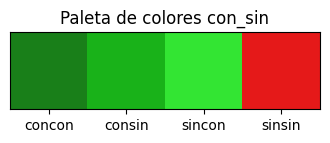

In [318]:
palette = list(con_sin_colors.values())
labels = list(con_sin_colors.keys())

sns.palplot(palette)
plt.xticks(range(len(labels)), labels)
plt.title('Paleta de colores con_sin')
plt.show()

In [319]:
ascensor_orden = ['con ascensor', 'sin ascensor']
equip_servicios_orden = ['con garaje, con trastero','con garaje, sin trastero', 'sin garaje, con trastero', 'sin garaje, sin trastero']
equip_espacios_de_ocio_orden = ['con jardín, con piscina','con jardín, sin piscina', 'sin jardín, con piscina','sin jardín, sin piscina']
equip_vistas_orden = ['con balcon, con terraza', 'con balcon, sin terraza', 'sin balcon, con terraza', 'sin balcon, sin terraza']
equip_clima_orden = ['con aire acondicionado, con calefacción','con aire acondicionado, sin calefacción', 'sin aire acondicionado, con calefacción','sin aire acondicionado, sin calefacción']

orden_colors = [con_sin_colors_list[0], con_sin_colors_list[1], con_sin_colors_list[2], con_sin_colors_list[3]]
ascensor_colors = [con_sin_colors_list[0], con_sin_colors_list[3]]
equip_servicios_colors = orden_colors
equip_espacios_de_ocio_colors = orden_colors
equip_vistas_colors = orden_colors
equip_clima_colors = orden_colors

/var/folders/3g/00ykkz597wqgzbnv_d0ctf000000gn/T/ipykernel_17975/4175706961.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right');


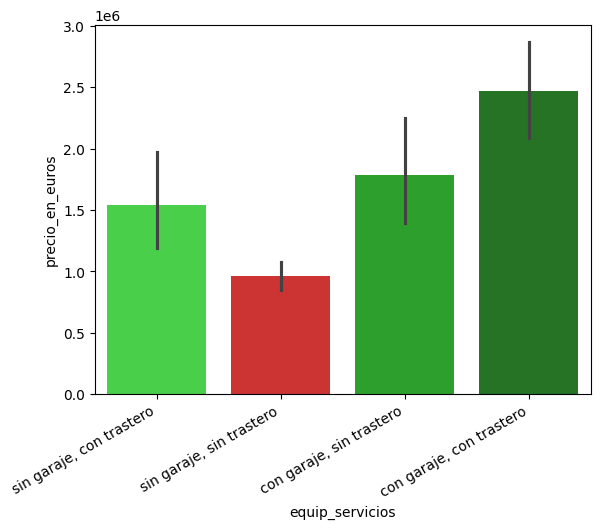

In [320]:
ax = sns.barplot(data=df, x="equip_servicios", y="precio_en_euros", hue='equip_servicios', hue_order=equip_servicios_orden, palette=equip_servicios_colors)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right');

In [321]:
### Paletas por 'zona' y 'subzona'
subzona_colors = {
    # Del primer loop (zonas principales)
    'sur':(0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
    'este': (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
    'oeste': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
    'norte': (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
    
    # Del segundo loop (subzonas de centro)
    'centro-norte': (0, 0, 0.2),
    'centro-medio': (0.1, 0.1, 0.6),
    'centro-centro': (0.1, 0.1, 0.95),
    'centro-sur': (0.7, 0.7, 1)
    }
zona_colors = {
    # Del primer loop (zonas principales)
    'centro': (0.03137254901960784, 0.4126259131103421, 0.6859669357939254),
    'sur':(0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
    'este': (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
    'oeste': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
    'norte': (0.6509803921568628, 0.9470588235294118, 0.42941176470588235)
}
centro_periferia_colors = {
'centro': (0.03137254901960784, 0.4126259131103421, 0.6859669357939254),
'periferia': (0.9, 0.2, 0.3)
}

In [322]:
subzonas_por_distrito = {
    'centro-norte': ['Tetuán', 'Chamartín'],
    'centro-medio': ['Chamberí', 'Barrio de Salamanca'],
    'centro-centro': ['Centro'],
    'centro-sur': ['Retiro', 'Arganzuela'],
    'sur': ['Carabanchel', 'Usera', 'Puente de Vallecas', 'Villaverde', 'Villa de Vallecas'],
    'este': ['Ciudad Lineal', 'San Blas', 'Moratalaz', 'Vicálvaro'],
    'oeste': ['Moncloa', 'Latina', 'Fuencarral'],
    'norte': ['Hortaleza', 'Barajas']
}
subzona_colors = {
    # zonas principales
    'sur': (0.90, 0.54, 0.76),  # Inverso cromático de norte
    'este': (0.60, 0.20, 0.40), # Inverso cromático de oeste
    'oeste': (0.65, 0.84, 0.32),
    'norte': (0.12, 0.5, 0.2),
     # subzonas centro
    'centro-norte': (0, 0, 0.2),
    'centro-medio': (0.1, 0.1, 0.9),
    'centro-centro': (0.4, 0.6, 1),
    'centro-sur': (0.1, 1, 1)
    }
distrito_colors = {
    distrito: subzona_colors[subzona]
    for subzona, distritos in subzonas_por_distrito.items()
    for distrito in distritos
}

<Axes: xlabel='precio_en_euros', ylabel='Density'>

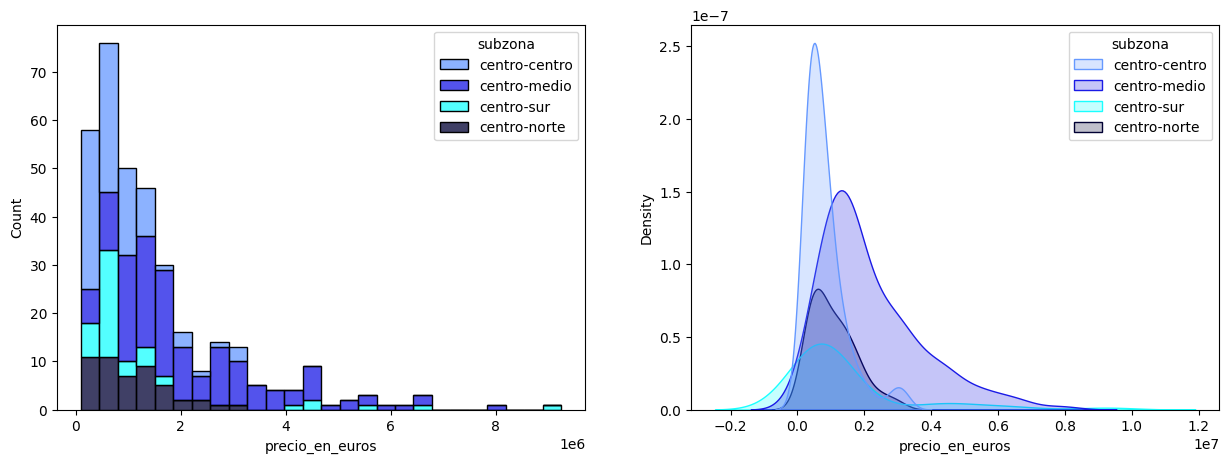

In [323]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df_pisos_sin_outliers_metros_cuadrados[df_pisos_sin_outliers_metros_cuadrados['centro_periferia'] == 'centro'], ax=ax1,
x="precio_en_euros", hue="subzona", fill=True, multiple="stack", palette=subzona_colors)
sns.kdeplot(data=df_pisos_sin_outliers_metros_cuadrados[df_pisos_sin_outliers_metros_cuadrados['centro_periferia'] == 'centro'], ax=ax2,
x="precio_en_euros", hue="subzona", fill=True, palette=subzona_colors)

## 5.4 DF por filas


In [324]:
### Sub DataFrames por `zona` y `subzona`
df_centro = df[df['centro_periferia'] == 'centro']
df_periferia = df[df['centro_periferia'] == 'periferia']
df_zcentro = df[df['zona'] == 'centro']
df_zsur = df[df['zona'] == 'sur']
df_zeste = df[df['zona'] == 'este']
df_zoeste = df[df['zona'] == 'oeste']
df_znorte = df[df['zona'] == 'norte']

### Sub DataFrames por `tipo_inmueble`:
df_chalets = df[df['tipo_inmueble'] == 'chalet']
df_pisos = df[df['tipo_inmueble'] == 'piso']


## 5.5 DF por columnas

In [325]:
### Sub DataFrames de `precios`
df_precios = df[price_sqm_cols]
df_precios_centro = df[price_sqm_cols + ['centro_periferia']]
df_precios_zonas = df[price_sqm_cols + ['zona', 'subzona']]
df_precios_numeric = df[price_sqm_cols + planta_y_estancias_cols]
df_precios_categ = df[price_sqm_cols + categ_cols]
df_precios_equip = df[price_sqm_cols + equip_cols]


## 5.6 DF GROUPBY

### A. `price_sqm_cols`

In [326]:
### `price_sqm_cols` por `zona`
df_gb_precio_y_sqm_por_zonas = df.groupby('zona')[price_sqm_cols].agg(['mean', 'std', 'count'])
df_gb_precio_y_sqm_por_zonas

precio_en_euros                     metros_cuadrados                    \
                  mean           std count             mean         std count   
zona                                                                            
centro    1.747277e+06  1.720394e+06   365       170.317808  133.275897   365   
este      4.310626e+05  2.901124e+05    69        82.565217   36.291904    69   
norte     1.234098e+06  1.281151e+06    48       248.687500  282.232073    48   
oeste     1.982741e+06  2.183357e+06    56       417.464286  532.815300    56   
sur       2.671110e+05  1.165038e+05    72        83.430556   37.056039    72   

       precio_el_metro_cuadrado                     
                           mean          std count  
zona                                                
centro              9428.145519  3443.093116   365  
este                5054.613897  1988.384657    69  
norte               5315.350064  1415.755934    48  
oeste               5179.416179  2028.710572    56  
sur                 3346.876548  1038.107001    72

In [327]:
### `price_sqm_cols` por `subzona`
df_gb_precio_y_sqm_por_subzonas = df.groupby('subzona')[price_sqm_cols].agg(['mean', 'std', 'count'])
df_gb_precio_y_sqm_por_subzonas

precio_en_euros                     metros_cuadrados  \
                         mean           std count             mean   
subzona                                                              
centro-centro    8.150485e+05  6.353087e+05   101        98.970297   
centro-medio     2.485704e+06  1.885457e+06   165       212.654545   
centro-norte     1.396345e+06  1.344114e+06    53       186.679245   
centro-sur       1.549757e+06  1.966193e+06    46       156.260870   
este             4.310626e+05  2.901124e+05    69        82.565217   
norte            1.234098e+06  1.281151e+06    48       248.687500   
oeste            1.982741e+06  2.183357e+06    56       417.464286   
sur              2.671110e+05  1.165038e+05    72        83.430556   

                                precio_el_metro_cuadrado                     
                      std count                     mean          std count  
subzona                                                                      
centro-centro   53.326064   101              7902.991109  2660.448923   101  
centro-medio   129.912712   165             11270.385662  3266.373682   165  
centro-norte   187.879132    53              7399.687716  2076.434700    53  
centro-sur     128.634268    46              8505.954978  3594.174049    46  
este            36.291904    69              5054.613897  1988.384657    69  
norte          282.232073    48              5315.350064  1415.755934    48  
oeste          532.815300    56              5179.416179  2028.710572    56  
sur             37.056039    72              3346.876548  1038.107001    72

In [328]:
### `price_sqm_cols` por `metros_cuadrados_rangos_xl`
df['metros_cuadrados_rangos_xl'] = pd.Categorical(    df['metros_cuadrados_rangos_xl'],     categories=metros_cuadrados_rangos_xl_orden,     ordered=True)

df_gb_precio_y_sqm_por_metros_cuadrados_rangos = df.groupby('metros_cuadrados_rangos_xl')[price_sqm_cols].agg(['mean', 'std', 'count'])
df_gb_precio_y_sqm_por_metros_cuadrados_rangos

/var/folders/3g/00ykkz597wqgzbnv_d0ctf000000gn/T/ipykernel_17975/606706716.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_gb_precio_y_sqm_por_metros_cuadrados_rangos = df.groupby('metros_cuadrados_rangos_xl')[price_sqm_cols].agg(['mean', 'std', 'count'])


precio_en_euros                      \
                                      mean           std count   
metros_cuadrados_rangos_xl                                       
0-30                          2.041000e+05  7.996853e+04     9   
31-60                         2.983836e+05  1.524020e+05    86   
61-120                        5.573821e+05  3.161936e+05   243   
121-240                       1.441401e+06  6.771485e+05   155   
241-500                       3.720620e+06  1.916078e+06    85   
501<                          4.824688e+06  1.939335e+06    32   

                           metros_cuadrados                    \
                                       mean         std count   
metros_cuadrados_rangos_xl                                      
0-30                              26.555556    3.643869     9   
31-60                             49.604651    8.121546    86   
61-120                            86.353909   17.267172   243   
121-240                          165.851613   34.597086   155   
241-500                          341.482353   70.879444    85   
501<                             905.093750  481.736266    32   

                           precio_el_metro_cuadrado                     
                                               mean          std count  
metros_cuadrados_rangos_xl                                              
0-30                                    7536.847782  2402.577773     9  
31-60                                   6074.601323  2894.311648    86  
61-120                                  6407.468499  3243.945891   243  
121-240                                 8571.987765  3270.606597   155  
241-500                                10717.668808  4473.884569    85  
501<                                    5914.954760  3039.666200    32

In [329]:
### `price_sqm_cols`por `tipo_inmueble`
df_gb_precio_y_sqm_por_tipo_inmueble = df.groupby('tipo_inmueble')[price_sqm_cols].agg(['mean', 'std', 'count'])
df_gb_precio_y_sqm_por_tipo_inmueble

precio_en_euros                     metros_cuadrados  \
                         mean           std count             mean   
tipo_inmueble                                                        
chalet           3.396636e+06  2.160246e+06    44       696.090909   
piso             1.250088e+06  1.491046e+06   566       138.793286   

                                precio_el_metro_cuadrado                     
                      std count                     mean          std count  
tipo_inmueble                                                                
chalet         524.759427    44              5310.326999  1985.603808    44  
piso           105.040682   566              7672.343296  3792.385267   566

In [330]:
### `price_sqm_cols`por `planta_rangos`
df_gb_precio_y_sqm_por_planta_rangos = df.groupby('planta_rangos')[price_sqm_cols].agg(['mean', 'std', 'count'])
df_gb_precio_y_sqm_por_planta_rangos

precio_en_euros                     metros_cuadrados  \
                          mean           std count             mean   
planta_rangos                                                         
-1 Semi-sótano    3.297500e+05  1.884151e+05     4        59.750000   
0 (Bajo)          5.100569e+05  6.157102e+05    67        85.388060   
0 (Chalet)        3.396636e+06  2.160246e+06    44       696.090909   
1º                1.045071e+06  1.264832e+06   105       131.495238   
2º                1.439312e+06  1.794010e+06    99       150.888889   
3º                1.125992e+06  1.309589e+06   103       123.038835   
4º                1.360659e+06  1.489794e+06    70       152.042857   
5º                2.053100e+06  1.870214e+06    50       190.120000   
6º o 7º           1.806295e+06  1.740045e+06    48       172.187500   
8º o más          9.626000e+05  6.573045e+05    20       138.250000   

                                 precio_el_metro_cuadrado                     
                       std count                     mean          std count  
planta_rangos                                                                 
-1 Semi-sótano   31.584543     4              5520.645577   973.830382     4  
0 (Bajo)         59.489993    67              5471.797815  2714.893271    67  
0 (Chalet)      524.759427    44              5310.326999  1985.603808    44  
1º               98.520998   105              7046.387505  3620.923751   105  
2º              114.532046    99              7934.868846  3897.400903    99  
3º               82.383717   103              7621.990555  3895.347488   103  
4º              119.006325    70              7814.033325  3262.566879    70  
5º              123.509504    50              9841.652735  3973.117986    50  
6º o 7º         126.593613    48              9840.127004  3742.702758    48  
8º o más         61.957434    20              6598.723661  3194.813204    20

In [331]:
### `price_sqm_cols`por `nuevo_usado`
df_gb_precio_y_sqm_por_nuevo_usado = df.groupby('nuevo_usado')[price_sqm_cols].agg(['mean', 'std', 'count'])
df_gb_precio_y_sqm_por_nuevo_usado

precio_en_euros                     metros_cuadrados  \
                         mean           std count             mean   
nuevo_usado                                                          
obra_nueva       1.339908e+06  1.028956e+06    25       163.800000   
obra_usada       1.316588e+06  1.556678e+06   499       171.707415   
para_reformar    1.936352e+06  2.126653e+06    86       225.674419   

                                precio_el_metro_cuadrado                     
                      std count                     mean          std count  
nuevo_usado                                                                  
obra_nueva      98.756012    25              8626.291748  3980.125299    25  
obra_usada     231.512372   499              7430.589490  3644.191135   499  
para_reformar  206.063408    86              7589.293541  4193.473615    86

In [332]:
### `price_sqm_cols`por `exterior_interior_chalet`
df_gb_precio_y_sqm_por_exterior_interior_chalet = df.groupby('exterior_interior_chalet')[price_sqm_cols].agg(['mean', 'std', 'count'])
df_gb_precio_y_sqm_por_exterior_interior_chalet

precio_en_euros                     metros_cuadrados  \
                                    mean           std count             mean   
exterior_interior_chalet                                                        
chalet                      3.396636e+06  2.160246e+06    44       696.090909   
exterior                    1.356543e+06  1.558213e+06   496       147.270161   
interior                    4.957773e+05  3.570285e+05    70        78.728571   

                                           precio_el_metro_cuadrado  \
                                 std count                     mean   
exterior_interior_chalet                                              
chalet                    524.759427    44              5310.326999   
exterior                  107.634377   496              7827.571752   
interior                   55.313840    70              6572.438809   

                                             
                                  std count  
exterior_interior_chalet                     
chalet                    1985.603808    44  
exterior                  3853.597596   496  
interior                  3135.680842    70

In [333]:
### `price_sqm_cols`por `categ_cols`

#### Por garaje
df_gb_precio_y_sqm_por_garaje = df.groupby('garaje_num')[price_sqm_cols].agg(['mean', 'std', 'count'])
#### Por jardin
df_gb_precio_y_sqm_por_jardin = df.groupby('jardin_num')[price_sqm_cols].agg(['mean', 'std', 'count'])
#### Por piscina
df_gb_precio_y_sqm_por_piscina = df.groupby('piscina_num')[price_sqm_cols].agg(['mean', 'std', 'count'])
#### Por terraza
df_gb_precio_y_sqm_por_terrazas = df.groupby('terraza_num')[price_sqm_cols].agg(['mean', 'std', 'count'])
#### Por trastero
df_gb_precio_y_sqm_por_trasteros = df.groupby('trastero_num')[price_sqm_cols].agg(['mean', 'std', 'count'])
#### Por balcon
df_gb_precio_y_sqm_por_balcon = df.groupby('balcon_num')[price_sqm_cols].agg(['mean', 'std', 'count'])
#### Por aire_acondicionado
df_gb_precio_y_sqm_por_aire_acondicionado = df.groupby('aire_acondicionado_num')[price_sqm_cols].agg(['mean', 'std', 'count'])
#### Por calefaccion
df_gb_precio_y_sqm_por_calefaccion = df.groupby('calefaccion_num')[price_sqm_cols].agg(['mean', 'std', 'count'])
#### Por ascensor
df_gb_precio_y_sqm_por_ascensor = df.groupby('ascensor_num')[price_sqm_cols].agg(['mean', 'std', 'count'])


### B. `planta_y_estancias_cols`

In [334]:
### `planta_y_estancias_cols` por `zona`
df_gb_planta_y_estancias_por_zonas= df.groupby('zona')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count'])
df_gb_planta_y_estancias_por_zonas

planta                 total_estancias                  \
            mean       std count            mean       std count   
zona                                                               
centro  2.991781  2.094587   365        7.282192  2.502710   365   
este    2.478261  2.304782    69        5.956522  1.538093    69   
norte   2.625000  3.173192    48        8.104167  2.998153    48   
oeste   1.142857  2.307526    56        9.642857  4.105112    56   
sur     2.486111  2.373522    72        5.958333  1.271990    72   

       num_dormitorios                 num_aseos                  \
                  mean       std count      mean       std count   
zona                                                               
centro        2.884932  1.449865   365  2.397260  1.221822   365   
este          2.362319  0.969703    69  1.594203  0.734023    69   
norte         3.458333  1.761990    48  2.645833  1.344644    48   
oeste         4.517857  2.730242    56  3.125000  1.584728    56   
sur           2.430556  0.819247    72  1.527778  0.604495    72   

       metros_cuadrados                    
                   mean         std count  
zona                                       
centro       170.317808  133.275897   365  
este          82.565217   36.291904    69  
norte        248.687500  282.232073    48  
oeste        417.464286  532.815300    56  
sur           83.430556   37.056039    72

In [335]:
### `planta_y_estancias_cols` por `subzona`
df_gb_planta_y_estancias_por_subzonas = df.groupby('subzona')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count'])
df_gb_planta_y_estancias_por_subzonas

planta                 total_estancias                  \
                   mean       std count            mean       std count   
subzona                                                                   
centro-centro  2.396040  1.697523   101        5.881188  1.898879   101   
centro-medio   3.484848  2.064822   165        8.133333  2.377571   165   
centro-norte   2.905660  2.513534    53        7.509434  2.777815    53   
centro-sur     2.630435  2.101414    46        7.043478  2.440005    46   
este           2.478261  2.304782    69        5.956522  1.538093    69   
norte          2.625000  3.173192    48        8.104167  2.998153    48   
oeste          1.142857  2.307526    56        9.642857  4.105112    56   
sur            2.486111  2.373522    72        5.958333  1.271990    72   

              num_dormitorios                 num_aseos                  \
                         mean       std count      mean       std count   
subzona                                                                   
centro-centro        2.168317  1.273337   101  1.712871  0.791664   101   
centro-medio         3.193939  1.268266   165  2.939394  1.238099   165   
centro-norte         3.264151  1.809706    53  2.245283  1.124990    53   
centro-sur           2.913043  1.442622    46  2.130435  1.185256    46   
este                 2.362319  0.969703    69  1.594203  0.734023    69   
norte                3.458333  1.761990    48  2.645833  1.344644    48   
oeste                4.517857  2.730242    56  3.125000  1.584728    56   
sur                  2.430556  0.819247    72  1.527778  0.604495    72   

              metros_cuadrados                    
                          mean         std count  
subzona                                           
centro-centro        98.970297   53.326064   101  
centro-medio        212.654545  129.912712   165  
centro-norte        186.679245  187.879132    53  
centro-sur          156.260870  128.634268    46  
este                 82.565217   36.291904    69  
norte               248.687500  282.232073    48  
oeste               417.464286  532.815300    56  
sur                  83.430556   37.056039    72

In [336]:
### `planta_y_estancias_cols` por `metros_cuadrados_rangos_xl`
df['metros_cuadrados_rangos_xl'] = pd.Categorical(    df['metros_cuadrados_rangos_xl'],     categories=metros_cuadrados_rangos_xl_orden,     ordered=True)

df_gb_planta_y_estancias_por_metros_cuadrados_rangos = df.groupby('metros_cuadrados_rangos_xl')[planta_y_estancias_cols].agg(['mean', 'std', 'count'])
df_gb_planta_y_estancias_por_metros_cuadrados_rangos

/var/folders/3g/00ykkz597wqgzbnv_d0ctf000000gn/T/ipykernel_17975/2040949162.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_gb_planta_y_estancias_por_metros_cuadrados_rangos = df.groupby('metros_cuadrados_rangos_xl')[planta_y_estancias_cols].agg(['mean', 'std', 'count'])


planta                 total_estancias  \
                                mean       std count            mean   
metros_cuadrados_rangos_xl                                             
0-30                        1.888889  2.368778     9        3.555556   
31-60                       2.093023  2.283588    86        4.534884   
61-120                      2.687243  2.269298   243        6.148148   
121-240                     3.187097  2.264311   155        7.722581   
241-500                     3.117647  2.362463    85       10.164706   
501<                        0.718750  1.708317    32       14.062500   

                                           num_dormitorios                  \
                                 std count            mean       std count   
metros_cuadrados_rangos_xl                                                   
0-30                        0.527046     9        0.555556  0.527046     9   
31-60                       0.835924    86        1.476744  0.731264    86   
61-120                      1.463985   243        2.456790  0.941022   243   
121-240                     1.261495   155        3.167742  0.888742   155   
241-500                     1.564845    85        4.223529  0.891447    85   
501<                        2.354645    32        7.218750  2.210450    32   

                           num_aseos                  
                                mean       std count  
metros_cuadrados_rangos_xl                            
0-30                        1.000000  0.000000     9  
31-60                       1.058140  0.235380    86  
61-120                      1.691358  0.709591   243  
121-240                     2.554839  0.665884   155  
241-500                     3.941176  0.877672    85  
501<                        4.843750  0.574140    32

In [337]:
### `planta_y_estancias_cols` por `tipo_inmueble`
df_gb_planta_y_estancias_por_tipo_inmueble = df.groupby('tipo_inmueble')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count'])
df_gb_planta_y_estancias_por_tipo_inmueble

planta                 total_estancias                  \
                   mean       std count            mean       std count   
tipo_inmueble                                                             
chalet         0.000000  0.000000    44       12.431818  3.350791    44   
piso           2.883392  2.288217   566        6.855124  2.203826   566   

              num_dormitorios                 num_aseos                  \
                         mean       std count      mean       std count   
tipo_inmueble                                                             
chalet               6.159091  2.551271    44  4.272727  1.107346    44   
piso                 2.719081  1.236849   566  2.136042  1.124565   566   

              metros_cuadrados                    
                          mean         std count  
tipo_inmueble                                     
chalet              696.090909  524.759427    44  
piso                138.793286  105.040682   566

In [338]:
### `planta_y_estancias_cols` por `planta_rangos`
df_gb_planta_y_estancias_por_planta_rangos = df.groupby('planta_rangos')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count'])
df_gb_planta_y_estancias_por_planta_rangos

planta                 total_estancias                  \
                    mean       std count            mean       std count   
planta_rangos                                                              
-1 Semi-sótano -1.000000  0.000000     4        4.750000  0.957427     4   
0 (Bajo)        0.000000  0.000000    67        5.850746  2.196786    67   
0 (Chalet)      0.000000  0.000000    44       12.431818  3.350791    44   
1º              1.000000  0.000000   105        6.723810  2.054522   105   
2º              2.000000  0.000000    99        7.121212  2.255482    99   
3º              3.000000  0.000000   103        6.504854  2.043036   103   
4º              4.000000  0.000000    70        7.100000  2.432569    70   
5º              5.000000  0.000000    50        7.660000  1.756736    50   
6º o 7º         6.270833  0.449093    48        7.541667  2.333460    48   
8º o más        9.650000  2.323224    20        7.300000  1.976174    20   

               num_dormitorios                 num_aseos                  \
                          mean       std count      mean       std count   
planta_rangos                                                              
-1 Semi-sótano        1.750000  0.957427     4  1.000000  0.000000     4   
0 (Bajo)              2.208955  1.430589    67  1.641791  0.916209    67   
0 (Chalet)            6.159091  2.551271    44  4.272727  1.107346    44   
1º                    2.714286  1.149534   105  2.009524  1.060617   105   
2º                    2.868687  1.209203    99  2.252525  1.198157    99   
3º                    2.533981  1.170014   103  1.970874  1.079727   103   
4º                    2.871429  1.328849    70  2.228571  1.217879    70   
5º                    2.980000  0.891914    50  2.680000  0.998775    50   
6º o 7º               2.979167  1.296305    48  2.562500  1.165209    48   
8º o más              3.050000  1.234376    20  2.250000  0.910465    20   

               metros_cuadrados                    
                           mean         std count  
planta_rangos                                      
-1 Semi-sótano        59.750000   31.584543     4  
0 (Bajo)              85.388060   59.489993    67  
0 (Chalet)           696.090909  524.759427    44  
1º                   131.495238   98.520998   105  
2º                   150.888889  114.532046    99  
3º                   123.038835   82.383717   103  
4º                   152.042857  119.006325    70  
5º                   190.120000  123.509504    50  
6º o 7º              172.187500  126.593613    48  
8º o más             138.250000   61.957434    20

In [339]:
### `planta_y_estancias_cols` por `nuevo_usado`
df_gb_planta_y_estancias_por_nuevo_usado = df.groupby('nuevo_usado')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count'])

In [340]:
### `planta_y_estancias_cols` por `exterior_interior_chalet`
df_gb_planta_y_estancias_por_exterior_interior_chalet = df.groupby('exterior_interior_chalet')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count'])
df_gb_planta_y_estancias_por_exterior_interior_chalet

planta                 total_estancias            \
                              mean       std count            mean       std   
exterior_interior_chalet                                                       
chalet                    0.000000  0.000000    44       12.431818  3.350791   
exterior                  3.002016  2.335928   496        7.042339  2.195547   
interior                  2.042857  1.706218    70        5.528571  1.775203   

                               num_dormitorios                 num_aseos  \
                         count            mean       std count      mean   
exterior_interior_chalet                                                   
chalet                      44        6.159091  2.551271    44  4.272727   
exterior                   496        2.812500  1.212363   496  2.229839   
interior                    70        2.057143  1.214474    70  1.471429   

                                         metros_cuadrados                    
                               std count             mean         std count  
exterior_interior_chalet                                                     
chalet                    1.107346    44       696.090909  524.759427    44  
exterior                  1.136891   496       147.270161  107.634377   496  
interior                  0.756066    70        78.728571   55.313840    70

In [341]:
### `planta_y_estancias_cols` por `categ_cols

### Por garaje
df_gb_planta_y_estancias_por_garaje = df.groupby('garaje_num')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count'])
### Por jardin
df_gb_planta_y_estancias_por_jardin = df.groupby('jardin_num')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count'])
### Por piscina
df_gb_planta_y_estancias_por_piscina = df.groupby('piscina_num')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count'])
### Por terraza
df_gb_planta_y_estancias_por_terrazas = df.groupby('terraza_num')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count'])
### Por trastero
df_gb_planta_y_estancias_por_trasteros = df.groupby('trastero_num')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count'])
### Por balcon
df_gb_planta_y_estancias_por_balcon = df.groupby('balcon_num')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count'])
### Por aire_acondicionado
df_gb_planta_y_estancias_por_aire_acondicionado = df.groupby('aire_acondicionado_num')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count'])
### Por calefaccion
df_gb_planta_y_estancias_por_calefaccion = df.groupby('calefaccion_num')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count'])
### Por ascensor
df_gb_planta_y_estancias_por_ascensor = df.groupby('ascensor_num')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count'])

### C. `equip_cols_agg`

In [342]:
#### `equip_cols_agg` por `precio_en_euros`

## Percentiles para rangos
p20_precio_en_euros = df['precio_en_euros'].quantile(0.20)
p10_precio_en_euros = df['precio_en_euros'].quantile(0.10)
p25_precio_en_euros = df['precio_en_euros'].quantile(0.25)
p75_precio_en_euros = df['precio_en_euros'].quantile(0.75)
p90_precio_en_euros = df['precio_en_euros'].quantile(0.90)
p80_precio_en_euros = df['precio_en_euros'].quantile(0.80)

## Crear columna de variable
df['precio_en_euros_rangos'] = None
df.loc[df['precio_en_euros'] <= p10_precio_en_euros, 'precio_en_euros_rangos'] = '10% más barato (Percentil 10)'
df.loc[(df['precio_en_euros'] > p10_precio_en_euros) & (df['precio_en_euros'] <= p25_precio_en_euros), 'precio_en_euros_rangos'] = '15% barato-intermedio'
df.loc[(df['precio_en_euros'] > p25_precio_en_euros) & (df['precio_en_euros'] < p75_precio_en_euros), 'precio_en_euros_rangos'] = '50% central (IQR)'
df.loc[(df['precio_en_euros'] >= p75_precio_en_euros) & (df['precio_en_euros'] < p90_precio_en_euros), 'precio_en_euros_rangos'] = '15% caro-intermedio'
df.loc[df['precio_en_euros'] >= p90_precio_en_euros, 'precio_en_euros_rangos'] = '10% más caro (Percentil 90)'

## Crear df de distribución de `precio_en_euros_rangos`
df_P20 = df[df['precio_en_euros'] < p20_precio_en_euros]
df_P10 = df[df['precio_en_euros'] < p10_precio_en_euros]
df_P10_P25 = df[(df['precio_en_euros'] >= p10_precio_en_euros) & (df['precio_en_euros'] < p25_precio_en_euros)]
df_IQR = df[(df['precio_en_euros'] >= p25_precio_en_euros) & (df['precio_en_euros'] < p75_precio_en_euros)]  # P25_P75
df_P75_P90 = df[(df['precio_en_euros'] >= p75_precio_en_euros) & (df['precio_en_euros'] < p90_precio_en_euros)]
df_P90 = df[df['precio_en_euros'] >= p90_precio_en_euros]
df_P80 = df[df['precio_en_euros'] < p80_precio_en_euros]



In [343]:
# Pisos IQR_precio_en_euros por `equip_cols_agg`
df_IQR_pee_gb_ascensor = df[df['precio_en_euros_rangos'] == '50% central (IQR)'].groupby('ascensor').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'ascensor': 'count'})
df_IQR_pee_gb_equip_servicios = df[df['precio_en_euros_rangos'] == '50% central (IQR)'].groupby('equip_servicios').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_servicios': 'count'})
df_IQR_pee_gb_equip_espacios_de_ocio = df[df['precio_en_euros_rangos'] == '50% central (IQR)'].groupby('equip_espacios_de_ocio').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_espacios_de_ocio': 'count'})
df_IQR_pee_gb_equip_vistas = df[df['precio_en_euros_rangos'] == '50% central (IQR)'].groupby('equip_vistas').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_vistas': 'count'})
df_IQR_pee_gb_equip_clima = df[df['precio_en_euros_rangos'] == '50% central (IQR)'].groupby('equip_clima').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_clima': 'count'})

In [344]:
# Pisos P10_precio_en_euros por equip_cols_agg
df_P10_pee_gb_ascensor = df[df['precio_en_euros_rangos'] == '10% más barato (Percentil 10)'].groupby('ascensor').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'ascensor': 'count'})
df_P10_pee_gb_equip_servicios = df[df['precio_en_euros_rangos'] == '10% más barato (Percentil 10)'].groupby('equip_servicios').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_servicios': 'count'})
df_P10_pee_gb_equip_espacios_de_ocio = df[df['precio_en_euros_rangos'] == '10% más barato (Percentil 10)'].groupby('equip_espacios_de_ocio').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_espacios_de_ocio': 'count'})
df_P10_pee_gb_equip_vistas = df[df['precio_en_euros_rangos'] == '10% más barato (Percentil 10)'].groupby('equip_vistas').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_vistas': 'count'})
df_P10_pee_gb_equip_clima = df[df['precio_en_euros_rangos'] == '10% más barato (Percentil 10)'].groupby('equip_clima').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_clima': 'count'})

In [345]:
# Pisos P90_precio_en_euros por equip_cols_agg
df_P90_pee_gb_ascensor = df[df['precio_en_euros_rangos'] == '10% más caro (Percentil 90)'].groupby('ascensor').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'ascensor': 'count'})
df_P90_pee_gb_equip_servicios = df[df['precio_en_euros_rangos'] == '10% más caro (Percentil 90)'].groupby('equip_servicios').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_servicios': 'count'})
df_P90_pee_gb_equip_espacios_de_ocio = df[df['precio_en_euros_rangos'] == '10% más caro (Percentil 90)'].groupby('equip_espacios_de_ocio').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_espacios_de_ocio': 'count'})
df_P90_pee_gb_equip_vistas = df[df['precio_en_euros_rangos'] == '10% más caro (Percentil 90)'].groupby('equip_vistas').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_vistas': 'count'})
df_P90_pee_gb_equip_clima = df[df['precio_en_euros_rangos'] == '10% más caro (Percentil 90)'].groupby('equip_clima').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_clima': 'count'})

In [346]:
df_IQR_pee_gb_ascensor = df_IQR_pee_gb_ascensor.sort_values(by=('ascensor', 'count'), ascending=False)
orden_equip_ascensor = df_IQR_pee_gb_ascensor.index.to_list()
df_IQR_pee_gb_ascensor.loc[:, ('ascensor', 'percent')] = (    df_IQR_pee_gb_ascensor[('ascensor', 'count')] /     df_IQR_pee_gb_ascensor[('ascensor', 'count')].sum() * 100)
df_IQR_pee_gb_ascensor

precio_el_metro_cuadrado              metros_cuadrados         \
                                 mean          std             mean median   
ascensor                                                                     
con ascensor              8031.946228  2749.706369       116.003984  107.0   
sin ascensor              5872.268103  2110.610887       127.830189  100.0   

                        ascensor             
                    std    count    percent  
ascensor                                     
con ascensor  46.661119      251  82.565789  
sin ascensor  96.825921       53  17.434211

In [347]:
df_P10_pee_gb_ascensor = df_P10_pee_gb_ascensor.loc[orden_equip_ascensor]
df_P10_pee_gb_ascensor.loc[:, ('ascensor', 'percent')] = (    df_P10_pee_gb_ascensor[('ascensor', 'count')] /     df_P10_pee_gb_ascensor[('ascensor', 'count')].sum() * 100)
df_P10_pee_gb_ascensor

precio_el_metro_cuadrado              metros_cuadrados         \
                                 mean          std             mean median   
ascensor                                                                     
con ascensor              4278.818557  1266.116700        50.333333   51.0   
sin ascensor              3401.622099  1399.839083        58.041667   55.0   

                        ascensor             
                    std    count    percent  
ascensor                                     
con ascensor  15.220600       15  23.809524  
sin ascensor  20.923323       48  76.190476

In [348]:
df_P90_pee_gb_ascensor = df_P90_pee_gb_ascensor.loc[orden_equip_ascensor]
df_P90_pee_gb_ascensor.loc[:, ('ascensor', 'percent')] = (    df_P90_pee_gb_ascensor[('ascensor', 'count')] /     df_P90_pee_gb_ascensor[('ascensor', 'count')].sum() * 100)
df_P90_pee_gb_ascensor

precio_el_metro_cuadrado              metros_cuadrados         \
                                 mean          std             mean median   
ascensor                                                                     
con ascensor             14187.495018  3361.688401       405.121951  402.0   
sin ascensor              5563.081724  1808.953050      1047.900000  848.0   

                         ascensor             
                     std    count    percent  
ascensor                                      
con ascensor   89.424324       41  67.213115  
sin ascensor  562.973581       20  32.786885

In [349]:
df_IQR_pee_gb_equip_servicios = df_IQR_pee_gb_equip_servicios.sort_values(by=('equip_servicios', 'count'), ascending=False)
orden_equip_servicios = df_IQR_pee_gb_equip_servicios.index.to_list()
df_IQR_pee_gb_equip_servicios.loc[:, ('equip_servicios', 'percent')] = (    df_IQR_pee_gb_equip_servicios[('equip_servicios', 'count')] /     df_IQR_pee_gb_equip_servicios[('equip_servicios', 'count')].sum() * 100)
df_IQR_pee_gb_equip_servicios

precio_el_metro_cuadrado               \
                                             mean          std   
equip_servicios                                                  
sin garaje, sin trastero              8041.827936  2792.971919   
con garaje, con trastero              6349.195659  2469.270873   
sin garaje, con trastero              8004.744049  2878.445934   
con garaje, sin trastero              7144.996662  2363.735220   

                         metros_cuadrados                   equip_servicios  \
                                     mean median        std           count   
equip_servicios                                                               
sin garaje, sin trastero       105.788889   97.5  43.086115             180   
con garaje, con trastero       153.920000  130.0  90.827902              50   
sin garaje, con trastero       117.820513  108.0  55.259137              39   
con garaje, sin trastero       130.257143  124.0  51.096416              35   

                                     
                            percent  
equip_servicios                      
sin garaje, sin trastero  59.210526  
con garaje, con trastero  16.447368  
sin garaje, con trastero  12.828947  
con garaje, sin trastero  11.513158

In [350]:
df_P10_pee_gb_equip_servicios = df_P10_pee_gb_equip_servicios.loc[['sin garaje, sin trastero', 'sin garaje, con trastero', 'con garaje, sin trastero']]
df_P10_pee_gb_equip_servicios.loc[:, ('equip_servicios', 'percent')] = (    df_P10_pee_gb_equip_servicios[('equip_servicios', 'count')] /     df_P10_pee_gb_equip_servicios[('equip_servicios', 'count')].sum() * 100)
df_P10_pee_gb_equip_servicios

precio_el_metro_cuadrado               \
                                             mean          std   
equip_servicios                                                  
sin garaje, sin trastero              3501.185952  1239.223053   
sin garaje, con trastero              4417.070235  2555.797481   
con garaje, sin trastero              4891.304348          NaN   

                         metros_cuadrados                   equip_servicios  \
                                     mean median        std           count   
equip_servicios                                                               
sin garaje, sin trastero        56.339286   53.0  18.421605              56   
sin garaje, con trastero        56.666667   57.5  33.844744               6   
con garaje, sin trastero        46.000000   46.0        NaN               1   

                                     
                            percent  
equip_servicios                      
sin garaje, sin trastero  88.888889  
sin garaje, con trastero   9.523810  
con garaje, sin trastero   1.587302

In [351]:
df_P90_pee_gb_equip_servicios = df_P90_pee_gb_equip_servicios.loc[orden_equip_servicios]
df_P90_pee_gb_equip_servicios.loc[:, ('equip_servicios', 'percent')] = (    df_P90_pee_gb_equip_servicios[('equip_servicios', 'count')] /     df_P90_pee_gb_equip_servicios[('equip_servicios', 'count')].sum() * 100)
df_P90_pee_gb_equip_servicios

precio_el_metro_cuadrado               \
                                             mean          std   
equip_servicios                                                  
sin garaje, sin trastero             13630.054000  4186.097781   
con garaje, con trastero              9415.727188  5171.366444   
sin garaje, con trastero             15420.604129  3072.775440   
con garaje, sin trastero             10328.347604  4192.026314   

                         metros_cuadrados                    equip_servicios  \
                                     mean median         std           count   
equip_servicios                                                                
sin garaje, sin trastero       401.875000  360.0  135.084110              16   
con garaje, con trastero       818.857143  685.0  567.579181              28   
sin garaje, con trastero       384.857143  401.0   70.798843               7   
con garaje, sin trastero       551.600000  428.5  256.623027              10   

                                     
                            percent  
equip_servicios                      
sin garaje, sin trastero  26.229508  
con garaje, con trastero  45.901639  
sin garaje, con trastero  11.475410  
con garaje, sin trastero  16.393443

In [352]:
df_IQR_pee_gb_equip_espacios_de_ocio = df_IQR_pee_gb_equip_espacios_de_ocio.sort_values(by=('equip_espacios_de_ocio', 'count'), ascending=False)
orden_equip_espacios_de_ocio = df_IQR_pee_gb_equip_espacios_de_ocio.index.to_list()
df_IQR_pee_gb_equip_espacios_de_ocio.loc[:, ('equip_espacios_de_ocio', 'percent')] = (    df_IQR_pee_gb_equip_espacios_de_ocio[('equip_espacios_de_ocio', 'count')] /     df_IQR_pee_gb_equip_espacios_de_ocio[('equip_espacios_de_ocio', 'count')].sum() * 100)
df_IQR_pee_gb_equip_espacios_de_ocio


precio_el_metro_cuadrado               \
                                            mean          std   
equip_espacios_de_ocio                                          
sin jardín, sin piscina              8001.643489  2737.101996   
con jardín, con piscina              5987.349081  2021.801399   
con jardín, sin piscina              5764.316617  1668.900069   
sin jardín, con piscina              8867.907487  3335.328860   

                        metros_cuadrados                    \
                                    mean median        std   
equip_espacios_de_ocio                                       
sin jardín, sin piscina       108.171053  100.0  43.888441   
con jardín, con piscina       154.575000  128.5  96.061916   
con jardín, sin piscina       142.888889  124.0  63.436758   
sin jardín, con piscina       137.444444  111.0  68.131553   

                        equip_espacios_de_ocio             
                                         count    percent  
equip_espacios_de_ocio                                     
sin jardín, sin piscina                    228  75.000000  
con jardín, con piscina                     40  13.157895  
con jardín, sin piscina                     18   5.921053  
sin jardín, con piscina                     18   5.921053

In [353]:
df_P10_pee_gb_equip_espacios_de_ocio = df_P10_pee_gb_equip_espacios_de_ocio.loc[['sin jardín, sin piscina', 'con jardín, con piscina', 'con jardín, sin piscina']]
df_P10_pee_gb_equip_espacios_de_ocio.loc[:, ('equip_espacios_de_ocio', 'percent')] = (    df_P10_pee_gb_equip_espacios_de_ocio[('equip_espacios_de_ocio', 'count')] /     df_P10_pee_gb_equip_espacios_de_ocio[('equip_espacios_de_ocio', 'count')].sum() * 100)
df_P10_pee_gb_equip_espacios_de_ocio

precio_el_metro_cuadrado               \
                                            mean          std   
equip_espacios_de_ocio                                          
sin jardín, sin piscina              3589.256268  1435.350802   
con jardín, con piscina              4699.573743   271.148022   
con jardín, sin piscina              3147.435897   970.005456   

                        metros_cuadrados                    \
                                    mean median        std   
equip_espacios_de_ocio                                       
sin jardín, sin piscina        56.254237   53.0  20.458194   
con jardín, con piscina        48.500000   48.5   3.535534   
con jardín, sin piscina        62.500000   62.5   3.535534   

                        equip_espacios_de_ocio             
                                         count    percent  
equip_espacios_de_ocio                                     
sin jardín, sin piscina                     59  93.650794  
con jardín, con piscina                      2   3.174603  
con jardín, sin piscina                      2   3.174603

In [354]:
df_P90_pee_gb_equip_espacios_de_ocio = df_P90_pee_gb_equip_espacios_de_ocio.loc[['sin jardín, sin piscina', 'con jardín, con piscina', 'con jardín, sin piscina']]
df_P90_pee_gb_equip_espacios_de_ocio.loc[:, ('equip_espacios_de_ocio', 'percent')] = (    df_P90_pee_gb_equip_espacios_de_ocio[('equip_espacios_de_ocio', 'count')] /     df_P90_pee_gb_equip_espacios_de_ocio[('equip_espacios_de_ocio', 'count')].sum() * 100)
df_P90_pee_gb_equip_espacios_de_ocio

precio_el_metro_cuadrado               \
                                            mean          std   
equip_espacios_de_ocio                                          
sin jardín, sin piscina             14145.562443  3421.581767   
con jardín, con piscina              5377.976808  1110.574575   
con jardín, sin piscina             14161.762185  3592.301235   

                        metros_cuadrados                     \
                                    mean median         std   
equip_espacios_de_ocio                                        
sin jardín, sin piscina       403.461538  402.0   91.067311   
con jardín, con piscina      1075.705882  848.0  587.797772   
con jardín, sin piscina       421.500000  421.5   72.831998   

                        equip_espacios_de_ocio             
                                         count    percent  
equip_espacios_de_ocio                                     
sin jardín, sin piscina                     39  67.241379  
con jardín, con piscina                     17  29.310345  
con jardín, sin piscina                      2   3.448276

In [355]:
df_IQR_pee_gb_equip_vistas = df_IQR_pee_gb_equip_vistas.sort_values(by=('equip_vistas', 'count'), ascending=False)
orden_equip_vistas = df_IQR_pee_gb_equip_vistas.index.to_list()
df_IQR_pee_gb_equip_vistas.loc[:, ('equip_vistas', 'percent')] = (    df_IQR_pee_gb_equip_vistas[('equip_vistas', 'count')] /     df_IQR_pee_gb_equip_vistas[('equip_vistas', 'count')].sum() * 100)
df_IQR_pee_gb_equip_vistas



precio_el_metro_cuadrado               \
                                            mean          std   
equip_vistas                                                    
sin balcon, sin terraza              8011.532511  2988.660686   
sin balcon, con terraza              6826.467727  2586.185373   
con balcon, sin terraza              7869.656114  2154.713379   
con balcon, con terraza              8348.047860  2563.508673   

                        metros_cuadrados                   equip_vistas  \
                                    mean median        std        count   
equip_vistas                                                              
sin balcon, sin terraza       104.582192   98.5  38.868613          146   
sin balcon, con terraza       136.329670  115.0  79.269169           91   
con balcon, sin terraza       118.562500  102.5  54.429696           48   
con balcon, con terraza       132.947368  127.0  54.264244           19   

                                    
                           percent  
equip_vistas                        
sin balcon, sin terraza  48.026316  
sin balcon, con terraza  29.934211  
con balcon, sin terraza  15.789474  
con balcon, con terraza   6.250000

In [356]:
df_P10_pee_gb_equip_vistas = df_P10_pee_gb_equip_vistas.loc[orden_equip_vistas]
df_P10_pee_gb_equip_vistas.loc[:, ('equip_vistas', 'percent')] = (    df_P10_pee_gb_equip_vistas[('equip_vistas', 'count')] /     df_P10_pee_gb_equip_vistas[('equip_vistas', 'count')].sum() * 100)
df_P10_pee_gb_equip_vistas

precio_el_metro_cuadrado               \
                                            mean          std   
equip_vistas                                                    
sin balcon, sin terraza              3707.822918  1445.571971   
sin balcon, con terraza              2486.981107   816.066283   
con balcon, sin terraza              3600.000000          NaN   
con balcon, con terraza              3137.065637   614.281953   

                        metros_cuadrados                   equip_vistas  \
                                    mean median        std        count   
equip_vistas                                                              
sin balcon, sin terraza        54.535714   52.0  19.226841           56   
sin balcon, con terraza        75.000000   67.0  27.055499            4   
con balcon, sin terraza        50.000000   50.0        NaN            1   
con balcon, con terraza        68.500000   68.5   7.778175            2   

                                    
                           percent  
equip_vistas                        
sin balcon, sin terraza  88.888889  
sin balcon, con terraza   6.349206  
con balcon, sin terraza   1.587302  
con balcon, con terraza   3.174603

In [357]:
df_P90_pee_gb_equip_vistas = df_P90_pee_gb_equip_vistas.loc[orden_equip_vistas]
df_P90_pee_gb_equip_vistas.loc[:, ('equip_vistas', 'percent')] = (    df_P90_pee_gb_equip_vistas[('equip_vistas', 'count')] /     df_P90_pee_gb_equip_vistas[('equip_vistas', 'count')].sum() * 100)
df_P90_pee_gb_equip_vistas


precio_el_metro_cuadrado               \
                                            mean          std   
equip_vistas                                                    
sin balcon, sin terraza             12773.293440  4153.245882   
sin balcon, con terraza              8561.867922  4609.057005   
con balcon, sin terraza             13939.958638  4452.419841   
con balcon, con terraza              9282.595230  5310.962052   

                        metros_cuadrados                    equip_vistas  \
                                    mean median         std        count   
equip_vistas                                                               
sin balcon, sin terraza       450.062500  402.0  136.528614           16   
sin balcon, con terraza       768.277778  762.5  361.619853           18   
con balcon, sin terraza       434.111111  406.0  192.967504           18   
con balcon, con terraza       969.333333  670.0  879.130536            9   

                                    
                           percent  
equip_vistas                        
sin balcon, sin terraza  26.229508  
sin balcon, con terraza  29.508197  
con balcon, sin terraza  29.508197  
con balcon, con terraza  14.754098

In [358]:
df_IQR_pee_gb_equip_clima = df_IQR_pee_gb_equip_clima.sort_values(by=('equip_clima', 'count'), ascending=False)
orden_equip_clima = df_IQR_pee_gb_equip_clima.index.to_list()
df_IQR_pee_gb_equip_clima.loc[:, ('equip_clima', 'percent')] = (    df_IQR_pee_gb_equip_clima[('equip_clima', 'count')] /     df_IQR_pee_gb_equip_clima[('equip_clima', 'count')].sum() * 100)
df_IQR_pee_gb_equip_clima


precio_el_metro_cuadrado               \
                                                     mean          std   
equip_clima                                                              
con aire acond., con calefacción              8019.386607  2639.981478   
sin aire acond., con calefacción              6368.221037  2160.758281   
con aire acond., sin calefacción              8424.567329  3202.049773   
sin aire acond., sin calefacción              7231.143275  3289.512670   

                                 metros_cuadrados                    \
                                             mean median        std   
equip_clima                                                           
con aire acond., con calefacción       115.903955  105.0  49.825569   
sin aire acond., con calefacción       115.338710  103.0  76.695255   
con aire acond., sin calefacción       113.750000  109.5  52.124233   
sin aire acond., sin calefacción       142.448276  124.0  67.588348   

                                 equip_clima             
                                       count    percent  
equip_clima                                              
con aire acond., con calefacción         177  58.223684  
sin aire acond., con calefacción          62  20.394737  
con aire acond., sin calefacción          36  11.842105  
sin aire acond., sin calefacción          29   9.539474

In [359]:
df_P10_pee_gb_equip_clima = df_P10_pee_gb_equip_clima.loc[orden_equip_clima]
df_P10_pee_gb_equip_clima.loc[:, ('equip_clima', 'percent')] = (    df_P10_pee_gb_equip_clima[('equip_clima', 'count')] /     df_P10_pee_gb_equip_clima[('equip_clima', 'count')].sum() * 100)
df_P10_pee_gb_equip_clima

precio_el_metro_cuadrado               \
                                                     mean          std   
equip_clima                                                              
con aire acond., con calefacción              4380.143811  1384.530612   
sin aire acond., con calefacción              3557.907927  1369.872956   
con aire acond., sin calefacción              3164.944641  1475.047564   
sin aire acond., sin calefacción              2656.620689   834.454268   

                                 metros_cuadrados                    \
                                             mean median        std   
equip_clima                                                           
con aire acond., con calefacción        46.565217   48.0  13.506988   
sin aire acond., con calefacción        57.714286   58.0  18.259635   
con aire acond., sin calefacción        64.333333   46.0  43.500958   
sin aire acond., sin calefacción        66.562500   65.0  19.886239   

                                 equip_clima             
                                       count    percent  
equip_clima                                              
con aire acond., con calefacción          23  36.507937  
sin aire acond., con calefacción          21  33.333333  
con aire acond., sin calefacción           3   4.761905  
sin aire acond., sin calefacción          16  25.396825

In [360]:
df_P90_pee_gb_equip_clima = df_P90_pee_gb_equip_clima.loc[orden_equip_clima]
df_P90_pee_gb_equip_clima.loc[:, ('equip_clima', 'percent')] = (    df_P90_pee_gb_equip_clima[('equip_clima', 'count')] /     df_P90_pee_gb_equip_clima[('equip_clima', 'count')].sum() * 100)
df_P90_pee_gb_equip_clima


precio_el_metro_cuadrado               \
                                                     mean          std   
equip_clima                                                              
con aire acond., con calefacción             10842.234156  5622.236486   
sin aire acond., con calefacción              8952.641302  4597.418525   
con aire acond., sin calefacción             12164.117419  5077.766073   
sin aire acond., sin calefacción             11222.480189  4573.703946   

                                 metros_cuadrados                     \
                                             mean median         std   
equip_clima                                                            
con aire acond., con calefacción         659.3125  467.0  373.066700   
sin aire acond., con calefacción         571.5000  650.5  194.024912   
con aire acond., sin calefacción         645.2800  401.0  602.559023   
sin aire acond., sin calefacción         537.5625  465.0  234.298092   

                                 equip_clima             
                                       count    percent  
equip_clima                                              
con aire acond., con calefacción          16  26.229508  
sin aire acond., con calefacción           4   6.557377  
con aire acond., sin calefacción          25  40.983607  
sin aire acond., sin calefacción          16  26.229508

## 6.6 DF CROSSTAB

Cruces de variables:
   1) `zona`-`exterior_interior_chalet`
   2) `zona`-`planta_rangos`
   3) `zona`-`metros_cuadrados_rangos`


### A. `zona`+`subzona` - `exterior_interior_chalet`

In [361]:
# CONTEOS TOTALES `zona`
df_cross_zona_ext_int_cont = pd.crosstab(    df['zona'],     df['exterior_interior'] )
df_cross_zona_ext_int_cont['total'] = df_cross_zona_ext_int_cont.sum(axis=1)
df_cross_zona_ext_int_cont.loc['Total'] = df_cross_zona_ext_int_cont.sum(axis=0)
df_cross_zona_ext_int_cont

exterior_interior,exterior,interior,total
zona,,,
centro,316,49,365
este,66,3,69
norte,45,3,48
oeste,52,4,56
sur,61,11,72
Total,540,70,610


In [362]:
# CONTEOS TOTALES `subzona`
df_cross_subzona_ext_int_cont = pd.crosstab(    df['subzona'],     df['exterior_interior'] )
df_cross_subzona_ext_int_cont['total'] = df_cross_subzona_ext_int_cont.sum(axis=1)
df_cross_subzona_ext_int_cont.loc['Total'] = df_cross_subzona_ext_int_cont.sum(axis=0)
df_cross_subzona_ext_int_cont

exterior_interior,exterior,interior,total
subzona,,,
centro-centro,77,24,101
centro-medio,148,17,165
centro-norte,49,4,53
centro-sur,42,4,46
este,66,3,69
norte,45,3,48
oeste,52,4,56
sur,61,11,72
Total,540,70,610


In [363]:
# % por COLUMNA (cada categoría suma 100%)
df_cross_zona_ext_int_col = pd.crosstab(    df['subzona'],     df['exterior_interior'],    normalize='columns')
df_cross_zona_ext_int_col.loc['Total'] = df_cross_zona_ext_int_col.sum(axis=0)
df_cross_zona_ext_int_col

exterior_interior,exterior,interior
subzona,,
centro-centro,0.142593,0.342857
centro-medio,0.274074,0.242857
centro-norte,0.090741,0.057143
centro-sur,0.077778,0.057143
este,0.122222,0.042857
norte,0.083333,0.042857
oeste,0.096296,0.057143
sur,0.112963,0.157143
Total,1.000000,1.000000


In [364]:
# % por FILA (cada zona suma 100%)
df_cross_zona_ext_int_ind = pd.crosstab(    df['zona'],     df['exterior_interior'],    normalize='index')

df_cross_zona_ext_int_ind['total'] = df_cross_zona_ext_int_ind.sum(axis=1)
df_cross_zona_ext_int_ind

exterior_interior,exterior,interior,total
zona,,,
centro,0.865753,0.134247,1.0
este,0.956522,0.043478,1.0
norte,0.937500,0.062500,1.0
oeste,0.928571,0.071429,1.0
sur,0.847222,0.152778,1.0


### B. `zona` - `planta_rangos`

In [365]:
# CONTEOS TOTALES
df_cross_zona_planta_rangos_cont = pd.crosstab(    df['zona'],     df['planta_rangos'] )

df_cross_zona_planta_rangos_cont['total'] = df_cross_zona_planta_rangos_cont.sum(axis=1)
df_cross_zona_planta_rangos_cont.loc['Total'] = df_cross_zona_planta_rangos_cont.sum(axis=0)
df_cross_zona_planta_rangos_cont

planta_rangos,-1 Semi-sótano,0 (Bajo),0 (Chalet),1º,2º,3º,4º,5º,6º o 7º,8º o más,total
zona,,,,,,,,,,,
centro,4,25,6,67,63,66,45,43,37,9,365
este,0,15,1,10,14,8,13,1,5,2,69
norte,0,7,11,3,8,3,5,4,4,3,48
oeste,0,10,24,6,8,4,2,0,0,2,56
sur,0,10,2,19,6,22,5,2,2,4,72
Total,4,67,44,105,99,103,70,50,48,20,610


In [366]:
# % por COLUMNA (cada categoría suma 100%)
df_cross_zona_planta_rangos_col = pd.crosstab(    df['zona'],     df['planta_rangos'],    normalize='columns')

df_cross_zona_planta_rangos_col.loc['Total'] = df_cross_zona_planta_rangos_col.sum(axis=0)
df_cross_zona_planta_rangos_col

planta_rangos,-1 Semi-sótano,0 (Bajo),0 (Chalet),1º,2º,3º,4º,5º,6º o 7º,8º o más
zona,,,,,,,,,,
centro,1.0,0.373134,0.136364,0.638095,0.636364,0.640777,0.642857,0.86,0.770833,0.45
este,0.0,0.223881,0.022727,0.095238,0.141414,0.077670,0.185714,0.02,0.104167,0.10
norte,0.0,0.104478,0.250000,0.028571,0.080808,0.029126,0.071429,0.08,0.083333,0.15
oeste,0.0,0.149254,0.545455,0.057143,0.080808,0.038835,0.028571,0.00,0.000000,0.10
sur,0.0,0.149254,0.045455,0.180952,0.060606,0.213592,0.071429,0.04,0.041667,0.20
Total,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.00


In [367]:
# % por FILA (cada zona suma 100%)
df_cross_zona_planta_rangos_ind = pd.crosstab(    df['zona'],     df['planta_rangos'],    normalize='index')

df_cross_zona_planta_rangos_ind['total'] = df_cross_zona_planta_rangos_ind.sum(axis=1)
df_cross_zona_planta_rangos_ind.loc['Total'] = df_cross_zona_planta_rangos_ind.sum(axis=0)
df_cross_zona_planta_rangos_ind

planta_rangos,-1 Semi-sótano,0 (Bajo),0 (Chalet),1º,2º,3º,4º,5º,6º o 7º,8º o más,total
zona,,,,,,,,,,,
centro,0.010959,0.068493,0.016438,0.183562,0.172603,0.180822,0.123288,0.117808,0.101370,0.024658,1.0
este,0.000000,0.217391,0.014493,0.144928,0.202899,0.115942,0.188406,0.014493,0.072464,0.028986,1.0
norte,0.000000,0.145833,0.229167,0.062500,0.166667,0.062500,0.104167,0.083333,0.083333,0.062500,1.0
oeste,0.000000,0.178571,0.428571,0.107143,0.142857,0.071429,0.035714,0.000000,0.000000,0.035714,1.0
sur,0.000000,0.138889,0.027778,0.263889,0.083333,0.305556,0.069444,0.027778,0.027778,0.055556,1.0
Total,0.010959,0.749178,0.716447,0.762021,0.768358,0.736248,0.521019,0.243412,0.284945,0.207413,5.0


### C. `zona` - `metros_cuadrados_rangos`

In [368]:
df['metros_cuadrados_rangos'] = pd.Categorical(    df['metros_cuadrados_rangos'],     categories=metros_cuadrados_rangos_orden,     ordered=True)

In [369]:
# CONTEOS TOTALES
df_cross_zona_metros_cuadrados_rangos_cont = pd.crosstab(    df['zona'],     df['metros_cuadrados_rangos'])

df_cross_zona_metros_cuadrados_rangos_cont['total'] = df_cross_zona_metros_cuadrados_rangos_cont.sum(axis=1)
df_cross_zona_metros_cuadrados_rangos_cont.loc['Total'] = df_cross_zona_metros_cuadrados_rangos_cont.sum(axis=0)
df_cross_zona_metros_cuadrados_rangos_cont

metros_cuadrados_rangos,0-35,61-75,76-100,101-120,121-150,151-200,201-250,251-300,301-500,501<,total
zona,,,,,,,,,,,
centro,12,38,52,30,52,47,29,20,42,9,331
este,0,15,17,9,3,2,0,1,0,0,47
norte,2,4,3,5,6,3,5,6,2,6,42
oeste,1,10,7,5,3,2,2,2,5,17,54
sur,3,20,17,11,6,1,0,1,0,0,59
Total,18,87,96,60,70,55,36,30,49,32,533


In [370]:
# % por COLUMNA (cada categoría suma 100%)
df_cross_zona_metros_cuadrados_rangos_col = pd.crosstab(    df['zona'],     df['metros_cuadrados_rangos'],    normalize='columns')

df_cross_zona_metros_cuadrados_rangos_col.loc['Total'] = df_cross_zona_metros_cuadrados_rangos_col.sum(axis=0)
df_cross_zona_metros_cuadrados_rangos_col

metros_cuadrados_rangos,0-35,61-75,76-100,101-120,121-150,151-200,201-250,251-300,301-500,501<
zona,,,,,,,,,,
centro,0.666667,0.436782,0.541667,0.500000,0.742857,0.854545,0.805556,0.666667,0.857143,0.28125
este,0.000000,0.172414,0.177083,0.150000,0.042857,0.036364,0.000000,0.033333,0.000000,0.00000
norte,0.111111,0.045977,0.031250,0.083333,0.085714,0.054545,0.138889,0.200000,0.040816,0.18750
oeste,0.055556,0.114943,0.072917,0.083333,0.042857,0.036364,0.055556,0.066667,0.102041,0.53125
sur,0.166667,0.229885,0.177083,0.183333,0.085714,0.018182,0.000000,0.033333,0.000000,0.00000
Total,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [371]:
# % por FILA (cada zona suma 100%)
df_cross_zona_metros_cuadrados_rangos_ind = pd.crosstab(    df['zona'],     df['metros_cuadrados_rangos'],    normalize='index')

df_cross_zona_metros_cuadrados_rangos_ind['total'] = df_cross_zona_metros_cuadrados_rangos_ind.sum(axis=1)
df_cross_zona_metros_cuadrados_rangos_ind

metros_cuadrados_rangos,0-35,61-75,76-100,101-120,121-150,151-200,201-250,251-300,301-500,501<,total
zona,,,,,,,,,,,
centro,0.036254,0.114804,0.157100,0.090634,0.157100,0.141994,0.087613,0.060423,0.126888,0.027190,1.0
este,0.000000,0.319149,0.361702,0.191489,0.063830,0.042553,0.000000,0.021277,0.000000,0.000000,1.0
norte,0.047619,0.095238,0.071429,0.119048,0.142857,0.071429,0.119048,0.142857,0.047619,0.142857,1.0
oeste,0.018519,0.185185,0.129630,0.092593,0.055556,0.037037,0.037037,0.037037,0.092593,0.314815,1.0
sur,0.050847,0.338983,0.288136,0.186441,0.101695,0.016949,0.000000,0.016949,0.000000,0.000000,1.0


# Subconjuntos (ALL)

In [372]:
# Outliers precio_el_metro_cuadrado
Q1_precio_el_metro_cuadrado = df['precio_el_metro_cuadrado'].quantile(0.25)
Q3_precio_el_metro_cuadrado = df['precio_el_metro_cuadrado'].quantile(0.75)
IQR_precio_el_metro_cuadrado = Q3_precio_el_metro_cuadrado - Q1_precio_el_metro_cuadrado

outliers_precio_el_metro_cuadrado = (df['precio_el_metro_cuadrado'] < Q1_precio_el_metro_cuadrado - 2*IQR_precio_el_metro_cuadrado) | (df['precio_el_metro_cuadrado'] > Q3_precio_el_metro_cuadrado + 2*IQR_precio_el_metro_cuadrado)
filas_outliers_precio_el_metro_cuadrado = df[outliers_precio_el_metro_cuadrado].index
df_outliers_precio_el_metro_cuadrado = df.loc[filas_outliers_precio_el_metro_cuadrado]
df_outliers_precio_el_metro_cuadrado = df_outliers_precio_el_metro_cuadrado.sort_values(by='precio_el_metro_cuadrado', ascending=True)

df_sin_outliers_precio_el_metro_cuadrado = df.drop(df_outliers_precio_el_metro_cuadrado.index)

# Outliers metros_cuadrados (df)
Q1_metros_cuadrados = df['metros_cuadrados'].quantile(0.25)
Q3_metros_cuadrados = df['metros_cuadrados'].quantile(0.75)
IQR_metros_cuadrados = Q3_metros_cuadrados - Q1_metros_cuadrados

outliers_metros_cuadrados = (df['metros_cuadrados'] < Q1_metros_cuadrados - 2*IQR_metros_cuadrados) | (df['metros_cuadrados'] > Q3_metros_cuadrados + 2*IQR_metros_cuadrados)
filas_outliers_metros_cuadrados = df[outliers_metros_cuadrados].index
df_outliers_metros_cuadrados = df.loc[filas_outliers_metros_cuadrados]
df_outliers_metros_cuadrados =df_outliers_metros_cuadrados.sort_values(by='metros_cuadrados', ascending=True)

df_sin_outliers_metros_cuadrados = df.drop(df_outliers_metros_cuadrados.index)

# Outliers metros_cuadrados (df_pisos)
df_pisos = df[df['tipo_inmueble'] == 'piso']
Q1_metros_cuadrados = df_pisos['metros_cuadrados'].quantile(0.25)
Q3_metros_cuadrados = df_pisos['metros_cuadrados'].quantile(0.75)
IQR_metros_cuadrados = Q3_metros_cuadrados - Q1_metros_cuadrados

outliers_pisos_metros_cuadrados = (df_pisos['metros_cuadrados'] < Q1_metros_cuadrados - 3*IQR_metros_cuadrados) | (df_pisos['metros_cuadrados'] > Q3_metros_cuadrados + 3*IQR_metros_cuadrados)
filas_pisos_outliers_metros_cuadrados = df_pisos[outliers_pisos_metros_cuadrados].index
df_pisos_outliers_metros_cuadrados = df_pisos.loc[filas_pisos_outliers_metros_cuadrados]
df_pisos_outliers_metros_cuadrados =df_pisos_outliers_metros_cuadrados.sort_values(by='metros_cuadrados', ascending=True)
num_outliers = outliers_pisos_metros_cuadrados.sum()

df_pisos_sin_outliers_metros_cuadrados = df_pisos.drop(df_pisos_outliers_metros_cuadrados.index)

# Outliers total_estancias
Q1_total_estancias = df['total_estancias'].quantile(0.25)
Q3_total_estancias = df['total_estancias'].quantile(0.75)
IQR_total_estancias = Q3_total_estancias - Q1_total_estancias

outliers_total_estancias = (df['total_estancias'] < Q1_total_estancias - 2*IQR_total_estancias) | (df['total_estancias'] > Q3_total_estancias + 2*IQR_total_estancias)
filas_outliers_total_estancias = df[outliers_total_estancias].index
df_outliers_total_estancias = df.loc[filas_outliers_total_estancias]
df_outliers_total_estancias =df_outliers_total_estancias.sort_values(by='total_estancias', ascending=True)

df_sin_outliers_total_estancias = df.drop(df_outliers_total_estancias.index)

### Columnas por categoría de datos
location_cols = ['barrio', 'centro_periferia', 'zona', 'subzona', 'distrito']
id_cols = ['id_centro_periferia', 'id_zona', 'id_distrito', 'id_metros_cuadrados_rangos']
price_sqm_cols = ['precio_en_euros', 'metros_cuadrados', 'precio_el_metro_cuadrado']
planta_y_estancias_cols = ['planta', 'total_estancias', 'num_dormitorios', 'num_aseos']
categ_cols = ['tipo_inmueble', 'planta_rangos', 'planta_rangos_xl', 'metros_cuadrados_rangos', 'metros_cuadrados_rangos_xl', 'precio_en_euros_rangos', 'precio_el_metro_cuadrado_rangos', 'tipo_planta', 'nuevo_usado', 'exterior_interior_chalet', 'exterior_interior']
equip_cols = ['garaje', 'jardin', 'piscina', 'terraza', 'trastero', 'balcon', 'aire_acondicionado', 'calefaccion', 'ascensor']
equip_cols_num = ['garaje_num', 'jardin_num', 'piscina_num', 'terraza_num', 'trastero_num', 'balcon_num', 'aire_acondicionado_num', 'calefaccion_num', 'ascensor_num']
equip_cols_agg = ['equip_servicios', 'equip_espacios_de_ocio', 'equip_vistas', 'equip_clima']

ascensor_col = ["ascensor"]
servicios_cols = ["garaje", "trastero"]
espacios_de_ocio_cols = ['jardin', 'piscina']
vistas_cols = ['balcon', 'terraza']
clima_cols = ['aire_acondicionado', 'calefaccion']

data_cols = location_cols + price_sqm_cols + planta_y_estancias_cols + categ_cols + equip_cols

### Columnas por 'zona' y 'subzona'
zonas = (df.sort_values('id_zona')['zona'].drop_duplicates().to_numpy()).tolist()  # único y ordenado por id_zona
subzonas = (df.sort_values('id_subzona')['subzona'].drop_duplicates().to_numpy()).tolist()  # único y ordenado por id_zona

## Ordenaciones

planta_rangos_orden = df['planta_rangos'].value_counts().index
tipo_inmueble_orden = df['tipo_inmueble'].value_counts().index
centro_periferia_orden = df['centro_periferia'].value_counts().index
zonas_orden = list(df['zona'].value_counts().index)
subzonas_centro_orden = ['centro-medio','centro-centro','centro-norte','centro-sur']
subzonas_periferia_orden = ['sur', 'este', 'oeste', 'norte']
subzonas_orden = ['centro-medio','centro-centro','centro-sur','centro-norte','norte', 'oeste', 'este', 'sur']
subzonas_orden_pal = ['centro-norte','centro-medio','centro-centro','centro-sur','norte', 'oeste', 'este', 'sur']
subzonas_orden_count = ['centro-medio', 'centro-centro', 'sur', 'este', 'oeste', 'centro-norte','norte', 'centro-sur']
zonas_orden_count = ['sur', 'este', 'norte','oeste']
planta_rangos_orden = ['-1 Semi-sótano', '0 (Bajo)', '0 (Chalet)', '1º', '2º', '3º', '4º', '5º', '6º o 7º', '8º o más']
planta_rangos_xl_orden = ['0 (Bajo o Semi-S.)', '0 (Chalet)', '1º - 3º', '4º - 5º', '6º o 7º', '8º o más']
planta_pisos_rangos_xl_orden = ['0 (Bajo o Semi-S.)', '1º - 3º', '4º - 5º', '6º o 7º', '8º o más']
metros_cuadrados_rangos_orden = ['0-35', '36-60', '61-75', '76-100', '101-120', '121-150', '151-200', '201-250', '251-300', '301-500', '501<']
metros_cuadrados_rangos_xl_orden = ['0-30' , '31-60', '61-120', '121-240', '241-500', '501<']
exterior_interior_chalet_orden = ['exterior', 'interior', 'chalet']
precio_en_euros_rangos_orden = ['10% más caro (Percentil 90)', '15% caro-intermedio','50% central (IQR)','15% barato-intermedio','10% más barato (Percentil 10)']
precio_el_metro_cuadrado_rangos_orden = ['10% pmc más alto (Percentil 90)', '15% pmc caro-intermedio', '50% pmc central (IQR)', '15% pmc barato-intermedio', '10% pmc más bajo (Percentil 10)']
nuevo_usado_orden = ['obra_nueva', 'obra_usada', 'para_reformar']
exterior_interior_orden = ['exterior', 'interior']
zonas_orden_pme = ['centro', 'norte', 'oeste', 'este', 'sur']

distritos_orden_count = df['distrito'].value_counts().index
distritos_orden = ['Tetuán', 'Chamartín', 'Chamberí', 'Barrio de Salamanca', 'Centro', 'Retiro', 'Arganzuela', 'Carabanchel', 'Usera', 'Puente de Vallecas', \
 'Villaverde', 'Villa de Vallecas', 'Ciudad Lineal', 'San Blas', 'Moratalaz', 'Vicálvaro', 'Moncloa', 'Latina', 'Fuencarral', 'Hortaleza', 'Barajas']

subzonas_por_distrito = {
    'centro-norte': ['Tetuán', 'Chamartín'],
    'centro-medio': ['Chamberí', 'Barrio de Salamanca'],
    'centro-centro': ['Centro'],
    'centro-sur': ['Retiro', 'Arganzuela'],
    'sur': ['Carabanchel', 'Usera', 'Puente de Vallecas', 'Villaverde', 'Villa de Vallecas'],
    'este': ['Ciudad Lineal', 'San Blas', 'Moratalaz', 'Vicálvaro'],
    'oeste': ['Moncloa', 'Latina', 'Fuencarral'],
    'norte': ['Hortaleza', 'Barajas']
}


## Paletas

centro_periferia_colors = {
'centro': (0.03137254901960784, 0.4126259131103421, 0.6859669357939254),
'periferia': (0.9, 0.2, 0.3)
}

subzona_colors = {
    # Del primer loop (zonas principales)
    'sur': (0.90, 0.54, 0.76),  # Inverso cromático de norte
    'este': (0.60, 0.20, 0.40), # Inverso cromático de oeste
    'oeste': (0.65, 0.84, 0.32),
    'norte': (0.12, 0.5, 0.2),
    
    # Del segundo loop (subzonas de centro)
    'centro-norte': (0, 0, 0.2),
    'centro-medio': (0.1, 0.1, 0.9),
    'centro-centro': (0.4, 0.6, 1),
    'centro-sur': (0.1, 1, 1)
    }
zona_colors = {
    # Del primer loop (zonas principales)
    'centro': (0.03137254901960784, 0.4126259131103421, 0.6859669357939254),
    'sur': (0.90, 0.54, 0.76),  # Inverso cromático de norte
    'este': (0.60, 0.20, 0.40), # Inverso cromático de oeste
    'oeste': (0.65, 0.84, 0.32),
    'norte': (0.12, 0.5, 0.2),
}

distrito_colors = {distrito: subzona_colors[subzona] for subzona, distritos in subzonas_por_distrito.items() for distrito in distritos}

precio_en_euros_rangos_colors = {
    '10% más caro (Percentil 90)': (0, 1, 0) ,
    '15% caro-intermedio': (0.1, 0.5, 0.1),
    '50% central (IQR)': (0.5, 0.5, 0.5),
    '15% barato-intermedio': (0.6, 0.2, 0.2),
    '10% más barato (Percentil 10)': (1, 0, 0)
}

precio_el_metro_cuadrado_rangos_colors = {
    '10% pmc más alto (Percentil 90)': (0, 1, 0) ,
    '15% pmc caro-intermedio': (0.1, 0.5, 0.1),
    '50% pmc central (IQR)': (0.5, 0.5, 0.5),
    '15% pmc barato-intermedio': (0.6, 0.2, 0.2),
    '10% pmc más bajo (Percentil 10)': (1, 0, 0)
}


### Paletas planta_rangos
metros_cuadrados_rangos_colors = dict(zip(metros_cuadrados_rangos_orden, sns.color_palette('winter', n_colors=len(metros_cuadrados_rangos_orden))))
metros_cuadrados_rangos_xl_colors = dict(zip(metros_cuadrados_rangos_xl_orden, sns.color_palette('winter', n_colors=len(metros_cuadrados_rangos_xl_orden))))
planta_rangos_colors = dict(zip(planta_rangos_orden, sns.color_palette('magma_r', n_colors=len(planta_rangos_orden))))
planta_rangos_xl_colors = dict(zip(planta_rangos_xl_orden, sns.color_palette('magma_r', n_colors=len(planta_rangos_xl_orden))))
tipo_inmueble_colors = {'piso': (0.2, 0.6, 1),'chalet': (1, 0.5, 0.6)}
exterior_interior_colors = dict(zip(exterior_interior_orden, sns.color_palette('Greens', n_colors=len(exterior_interior_orden))))
nuevo_usado_colors = dict(zip(nuevo_usado_orden, sns.color_palette('dark:salmon_r', n_colors=len(nuevo_usado_orden))))


### Paletas con_sin
sns.color_palette("Paired")
paleta = sns.color_palette("Paired")
mis_colores = [paleta[3], paleta[2], paleta[4], paleta[5]]
con_sin_colors = {
    'concon': (0.1, 0.5, 0.1),
    'consin': (0.1, 0.7, 0.1),
    'sincon': (0.2, 0.9, 0.2),
    'sinsin': (0.9, 0.1, 0.1)
}
con_sin_colors_list = [
    con_sin_colors['concon'],
    con_sin_colors['consin'],
    con_sin_colors['sincon'],
    con_sin_colors['sinsin']
]
ascensor_orden = ['con ascensor', 'sin ascensor']
equip_servicios_orden = ['con garaje, con trastero','con garaje, sin trastero', 'sin garaje, con trastero', 'sin garaje, sin trastero']
equip_espacios_de_ocio_orden = ['con jardín, con piscina','con jardín, sin piscina', 'sin jardín, con piscina','sin jardín, sin piscina']
equip_vistas_orden = ['con balcon, con terraza', 'con balcon, sin terraza', 'sin balcon, con terraza', 'sin balcon, sin terraza']
equip_clima_orden = ['con aire acond., con calefacción','con aire acond., sin calefacción', 'sin aire acond., con calefacción','sin aire acond., sin calefacción']

orden_colors = [con_sin_colors_list[0], con_sin_colors_list[1], con_sin_colors_list[2], con_sin_colors_list[3]]
ascensor_colors = [con_sin_colors_list[0], con_sin_colors_list[3]]
equip_servicios_colors = orden_colors
equip_espacios_de_ocio_colors = orden_colors
equip_vistas_colors = orden_colors
equip_clima_colors = orden_colors


## DataFrames por filas

### Sub DataFrames por `zona` y `subzona`
df_centro = df[df['centro_periferia'] == 'centro']
df_periferia = df[df['centro_periferia'] == 'periferia']
df_zcentro = df[df['zona'] == 'centro']
df_zsur = df[df['zona'] == 'sur']
df_zeste = df[df['zona'] == 'este']
df_zoeste = df[df['zona'] == 'oeste']
df_znorte = df[df['zona'] == 'norte']

### Sub DataFrames por `tipo_inmueble`:
df_chalets = df[df['tipo_inmueble'] == 'chalet']
df_pisos = df[df['tipo_inmueble'] == 'piso']

# Pisos más baratos (en precio absoluto)
P10_precio_en_euros = df_pisos['precio_en_euros'].quantile(0.10)
P20_precio_en_euros = df_pisos['precio_en_euros'].quantile(0.20)
# Pisos más caros (en precio absoluto)
P80_precio_en_euros = df_pisos['precio_en_euros'].quantile(0.80)
P90_precio_en_euros = df_pisos['precio_en_euros'].quantile(0.90)

# IQR_pisos_precio_en_euros = Pisos ni caros ni baratos (en precio absoluto)
Q1_pisos_precio_en_euros = df_pisos['precio_en_euros'].quantile(0.25)
Q3_pisos_precio_en_euros = df_pisos['precio_en_euros'].quantile(0.75)
IQR_pisos_precio_en_euros = Q3_pisos_precio_en_euros - Q1_pisos_precio_en_euros

# df_pisos ni caros ni baratos (50% central)
df_pisos_IQR_precio_en_euros = df_pisos[    (df_pisos['precio_en_euros'] >= Q1_pisos_precio_en_euros - 2*IQR_pisos_precio_en_euros) &
    (df_pisos['precio_en_euros'] <= Q3_pisos_precio_en_euros + 2*IQR_pisos_precio_en_euros)]

# df_pisos baratos
df_pisos_P10_precio_en_euros = df_pisos[df_pisos['precio_en_euros'] < P10_precio_en_euros]
df_pisos_P20_precio_en_euros = df_pisos[df_pisos['precio_en_euros'] < P20_precio_en_euros]
# df_pisos caros
df_pisos_P80_precio_en_euros = df_pisos[df_pisos['precio_en_euros'] > P80_precio_en_euros]
df_pisos_P90_precio_en_euros = df_pisos[df_pisos['precio_en_euros'] > P90_precio_en_euros]

## DataFrames por columnas

### Sub DataFrames de `precios`
df_precios = df[price_sqm_cols]
df_precios_centro = df[price_sqm_cols + ['centro_periferia']]
df_precios_zonas = df[price_sqm_cols + ['zona', 'subzona']]
df_precios_numeric = df[price_sqm_cols + planta_y_estancias_cols]
df_precios_categ = df[price_sqm_cols + categ_cols]
df_precios_equip = df[price_sqm_cols + equip_cols]


### Groupby DataFrames

### `price_sqm_cols` por `zona`
df_gb_precio_y_sqm_por_zonas = df.groupby('zona')[price_sqm_cols].agg(['mean', 'std', 'count'])
df_gb_precio_y_sqm_por_subzonas = df.groupby('subzona')[price_sqm_cols].agg(['mean', 'std', 'count'])
df_gb_precio_y_sqm_por_tipo_inmueble = df.groupby('tipo_inmueble')[price_sqm_cols].agg(['mean', 'std', 'count'])
df_gb_precio_y_sqm_por_planta_rangos = df.groupby('planta_rangos')[price_sqm_cols].agg(['mean', 'std', 'count'])
df_gb_precio_y_sqm_por_nuevo_usado = df.groupby('nuevo_usado')[price_sqm_cols].agg(['mean', 'std', 'count'])
df_gb_precio_y_sqm_por_exterior_interior_chalet = df.groupby('exterior_interior_chalet')[price_sqm_cols].agg(['mean', 'std', 'count'])
### `price_sqm_cols` por `categ_cols
df_gb_precio_y_sqm_por_garaje = df.groupby('garaje_num')[price_sqm_cols].agg(['mean', 'std', 'count']) ### Por garaje
df_gb_precio_y_sqm_por_jardin = df.groupby('jardin_num')[price_sqm_cols].agg(['mean', 'std', 'count']) ### Por jardin
df_gb_precio_y_sqm_por_piscina = df.groupby('piscina_num')[price_sqm_cols].agg(['mean', 'std', 'count']) ### Por piscina
df_gb_precio_y_sqm_por_terrazas = df.groupby('terraza_num')[price_sqm_cols].agg(['mean', 'std', 'count']) ### Por terraza
df_gb_precio_y_sqm_por_trasteros = df.groupby('trastero_num')[price_sqm_cols].agg(['mean', 'std', 'count']) ### Por trastero
df_gb_precio_y_sqm_por_balcon = df.groupby('balcon_num')[price_sqm_cols].agg(['mean', 'std', 'count']) ### Por balcon
df_gb_precio_y_sqm_por_aire_acondicionado = df.groupby('aire_acondicionado_num')[price_sqm_cols].agg(['mean', 'std', 'count']) ### Por aire_acondicionado
df_gb_precio_y_sqm_por_calefaccion = df.groupby('calefaccion_num')[price_sqm_cols].agg(['mean', 'std', 'count']) ### Por calefaccion
df_gb_precio_y_sqm_por_ascensor = df.groupby('ascensor_num')[price_sqm_cols].agg(['mean', 'std', 'count']) ### Por ascensor

### `planta_y_estancias_cols` por `zona`
df_gb_planta_y_estancias_por_zonas= df.groupby('zona')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count'])
df_gb_planta_y_estancias_por_subzonas = df.groupby('subzona')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count'])
df_gb_planta_y_estancias_por_tipo_inmueble = df.groupby('tipo_inmueble')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count'])
df_gb_planta_y_estancias_por_planta_rangos = df.groupby('planta_rangos')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count'])
df_gb_planta_y_estancias_por_nuevo_usado = df.groupby('nuevo_usado')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count'])
df_gb_planta_y_estancias_por_exterior_interior_chalet = df.groupby('exterior_interior_chalet')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count'])
### `planta_y_estancias_cols` por categ_cols
df_gb_planta_y_estancias_por_garaje = df.groupby('garaje_num')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count']) ### Por garaje
df_gb_planta_y_estancias_por_jardin = df.groupby('jardin_num')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count']) ### Por jardin
df_gb_planta_y_estancias_por_piscina = df.groupby('piscina_num')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count']) ### Por piscina
df_gb_planta_y_estancias_por_terrazas = df.groupby('terraza_num')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count']) ### Por terraza
df_gb_planta_y_estancias_por_trasteros = df.groupby('trastero_num')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count']) ### Por trastero
df_gb_planta_y_estancias_por_balcon = df.groupby('balcon_num')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count']) ### Por balcon
df_gb_planta_y_estancias_por_aire_acondicionado = df.groupby('aire_acondicionado_num')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count']) ### Por aire_acondicionado
df_gb_planta_y_estancias_por_calefaccion = df.groupby('calefaccion_num')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count']) ### Por calefaccion
df_gb_planta_y_estancias_por_ascensor = df.groupby('ascensor_num')[planta_y_estancias_cols+['metros_cuadrados']].agg(['mean', 'std', 'count']) ### Por ascensor

### `equip_cols_agg` por `precio_en_euros`

## Percentiles para rangos en df total
p20_precio_en_euros = df['precio_en_euros'].quantile(0.25)
p10_precio_en_euros = df['precio_en_euros'].quantile(0.10)
p25_precio_en_euros = df['precio_en_euros'].quantile(0.25)
p75_precio_en_euros = df['precio_en_euros'].quantile(0.75)
p90_precio_en_euros = df['precio_en_euros'].quantile(0.90)
p80_precio_en_euros = df['precio_en_euros'].quantile(0.80)

## Percentiles para rangos df_pisos
p20_precio_en_euros_pisos = df_pisos['precio_en_euros'].quantile(0.25)
p10_precio_en_euros_pisos = df_pisos['precio_en_euros'].quantile(0.10)
p25_precio_en_euros_pisos = df_pisos['precio_en_euros'].quantile(0.25)
p75_precio_en_euros_pisos = df_pisos['precio_en_euros'].quantile(0.75)
p90_precio_en_euros_pisos = df_pisos['precio_en_euros'].quantile(0.90)
p80_precio_en_euros_pisos = df_pisos['precio_en_euros'].quantile(0.80)

## Crear columna de variable
df['precio_en_euros_rangos'] = None
df.loc[df['precio_en_euros'] <= p10_precio_en_euros, 'precio_en_euros_rangos'] = '10% más barato (Percentil 10)'
df.loc[(df['precio_en_euros'] > p10_precio_en_euros) & (df['precio_en_euros'] <= p25_precio_en_euros), 'precio_en_euros_rangos'] = '15% barato-intermedio'
df.loc[(df['precio_en_euros'] > p25_precio_en_euros) & (df['precio_en_euros'] < p75_precio_en_euros), 'precio_en_euros_rangos'] = '50% central (IQR)'
df.loc[(df['precio_en_euros'] >= p75_precio_en_euros) & (df['precio_en_euros'] < p90_precio_en_euros), 'precio_en_euros_rangos'] = '15% caro-intermedio'
df.loc[df['precio_en_euros'] >= p90_precio_en_euros, 'precio_en_euros_rangos'] = '10% más caro (Percentil 90)'

## Crear dfs de distribución de `precio_en_euros_rangos` para total viviendas
df_P10 = df[df['precio_en_euros'] < p10_precio_en_euros]
df_P20 = df[df['precio_en_euros'] < p20_precio_en_euros]
df_P25 = df[df['precio_en_euros'] < p25_precio_en_euros]
df_P10_P25 = df[(df['precio_en_euros'] >= p10_precio_en_euros) & (df['precio_en_euros'] < p25_precio_en_euros)]
df_IQR = df[(df['precio_en_euros'] >= p25_precio_en_euros) & (df['precio_en_euros'] < p75_precio_en_euros)]  # P25_P75
df_P75_P90 = df[(df['precio_en_euros'] >= p75_precio_en_euros) & (df['precio_en_euros'] < p90_precio_en_euros)]
df_P90 = df[df['precio_en_euros'] >= p90_precio_en_euros]
df_P75 = df[df['precio_en_euros'] < p75_precio_en_euros]
df_P80 = df[df['precio_en_euros'] < p80_precio_en_euros]

## Crear dfs de distribución de `precio_en_euros_rangos` para pisos
df_pisos_P10 = df_pisos[df_pisos['precio_en_euros'] < p10_precio_en_euros_pisos]
df_pisos_P20 = df_pisos[df_pisos['precio_en_euros'] < p20_precio_en_euros_pisos]
df_pisos_P25 = df_pisos[df_pisos['precio_en_euros'] < p25_precio_en_euros_pisos]
df_pisos_P10_P25 = df_pisos[(df_pisos['precio_en_euros'] >= p10_precio_en_euros_pisos) & (df_pisos['precio_en_euros'] < p25_precio_en_euros_pisos)]
df_pisos_IQR = df_pisos[(df_pisos['precio_en_euros'] >= p25_precio_en_euros_pisos) & (df_pisos['precio_en_euros'] < p75_precio_en_euros_pisos)]  # P25_P75
df_pisos_P75_P90 = df_pisos[(df_pisos['precio_en_euros'] >= p75_precio_en_euros_pisos) & (df_pisos['precio_en_euros'] < p90_precio_en_euros_pisos)]
df_pisos_P90 = df_pisos[df_pisos['precio_en_euros'] >= p90_precio_en_euros_pisos]
df_pisos_P75 = df_pisos[df_pisos['precio_en_euros'] < p75_precio_en_euros_pisos]
df_pisos_P80 = df_pisos[df_pisos['precio_en_euros'] < p80_precio_en_euros_pisos]

# IQR_pee
df_IQR_pee_gb_ascensor = df[df['precio_en_euros_rangos'] == '50% central (IQR)'].groupby('ascensor').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'ascensor': 'count'})
df_IQR_pee_gb_equip_servicios = df[df['precio_en_euros_rangos'] == '50% central (IQR)'].groupby('equip_servicios').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_servicios': 'count'})
df_IQR_pee_gb_equip_espacios_de_ocio = df[df['precio_en_euros_rangos'] == '50% central (IQR)'].groupby('equip_espacios_de_ocio').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_espacios_de_ocio': 'count'})
df_IQR_pee_gb_equip_vistas = df[df['precio_en_euros_rangos'] == '50% central (IQR)'].groupby('equip_vistas').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_vistas': 'count'})
df_IQR_pee_gb_equip_clima = df[df['precio_en_euros_rangos'] == '50% central (IQR)'].groupby('equip_clima').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_clima': 'count'})

# P10_pee
df_P10_pee_gb_ascensor = df[df['precio_en_euros_rangos'] == '10% más barato (Percentil 10)'].groupby('ascensor').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'ascensor': 'count'})
df_P10_pee_gb_equip_servicios = df[df['precio_en_euros_rangos'] == '10% más barato (Percentil 10)'].groupby('equip_servicios').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_servicios': 'count'})
df_P10_pee_gb_equip_espacios_de_ocio = df[df['precio_en_euros_rangos'] == '10% más barato (Percentil 10)'].groupby('equip_espacios_de_ocio').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_espacios_de_ocio': 'count'})
df_P10_pee_gb_equip_vistas = df[df['precio_en_euros_rangos'] == '10% más barato (Percentil 10)'].groupby('equip_vistas').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_vistas': 'count'})
df_P10_pee_gb_equip_clima = df[df['precio_en_euros_rangos'] == '10% más barato (Percentil 10)'].groupby('equip_clima').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_clima': 'count'})

# P90_pee
df_P90_pee_gb_ascensor = df[df['precio_en_euros_rangos'] == '10% más caro (Percentil 90)'].groupby('ascensor').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'ascensor': 'count'})
df_P90_pee_gb_equip_servicios = df[df['precio_en_euros_rangos'] == '10% más caro (Percentil 90)'].groupby('equip_servicios').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_servicios': 'count'})
df_P90_pee_gb_equip_espacios_de_ocio = df[df['precio_en_euros_rangos'] == '10% más caro (Percentil 90)'].groupby('equip_espacios_de_ocio').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_espacios_de_ocio': 'count'})
df_P90_pee_gb_equip_vistas = df[df['precio_en_euros_rangos'] == '10% más caro (Percentil 90)'].groupby('equip_vistas').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_vistas': 'count'})
df_P90_pee_gb_equip_clima = df[df['precio_en_euros_rangos'] == '10% más caro (Percentil 90)'].groupby('equip_clima').agg({'precio_el_metro_cuadrado': ['mean', 'std'],'metros_cuadrados': ['mean', 'median', 'std'], 'equip_clima': 'count'})


# Outliers precio_en_euros
Q1_precio_en_euros = df['precio_en_euros'].quantile(0.25)
Q3_precio_en_euros = df['precio_en_euros'].quantile(0.75)
IQR_precio_en_euros = Q3_precio_en_euros - Q1_precio_en_euros

outliers_precio_en_euros = (df['precio_en_euros'] < Q1_precio_en_euros - 2*IQR_precio_en_euros) | (df['precio_en_euros'] > Q3_precio_en_euros + 2*IQR_precio_en_euros)
filas_outliers_precio_en_euros = df[outliers_precio_en_euros].index
df_outliers_precio_en_euros = df.loc[filas_outliers_precio_en_euros]
df_outliers_precio_en_euros = df_outliers_precio_en_euros.sort_values(by='precio_en_euros', ascending=False)

df_sin_outliers_precio_en_euros = df.drop(df_outliers_precio_en_euros.index)

## DataFrames Crosstab

### `zona`-`exterior_interior`
#### CONTEOS TOTALES `zona`
df_cross_zona_ext_int_cont = pd.crosstab(    df['zona'],     df['exterior_interior'] )
df_cross_zona_ext_int_cont['total'] = df_cross_zona_ext_int_cont.sum(axis=1)
df_cross_zona_ext_int_cont.loc['Total'] = df_cross_zona_ext_int_cont.sum(axis=0)
#### CONTEOS TOTALES `subzona`
df_cross_subzona_ext_int_cont = pd.crosstab(    df['subzona'],     df['exterior_interior'] )
df_cross_subzona_ext_int_cont['total'] = df_cross_subzona_ext_int_cont.sum(axis=1)
df_cross_subzona_ext_int_cont.loc['Total'] = df_cross_subzona_ext_int_cont.sum(axis=0)
#### % por COLUMNA (cada categoría suma 100%)
df_cross_zona_ext_int_col = pd.crosstab(    df['subzona'],     df['exterior_interior'],    normalize='columns')
df_cross_zona_ext_int_col.loc['Total'] = df_cross_zona_ext_int_col.sum(axis=0)
#### % por FILA (cada zona suma 100%)
df_cross_zona_ext_int_ind = pd.crosstab(    df['zona'],     df['exterior_interior'],    normalize='index')
df_cross_zona_ext_int_ind['total'] = df_cross_zona_ext_int_ind.sum(axis=1)

### `zona`-`planta_rangos`
#### CONTEOS TOTALES `subzona`
df_cross_zona_planta_rangos_cont = pd.crosstab(    df['zona'],     df['planta_rangos'] )
df_cross_zona_planta_rangos_cont['total'] = df_cross_zona_planta_rangos_cont.sum(axis=1)
df_cross_zona_planta_rangos_cont.loc['Total'] = df_cross_zona_planta_rangos_cont.sum(axis=0)
#### % por COLUMNA (cada categoría suma 100%)
df_cross_zona_planta_rangos_col = pd.crosstab(    df['zona'],     df['planta_rangos'],    normalize='columns')
df_cross_zona_planta_rangos_col.loc['Total'] = df_cross_zona_planta_rangos_col.sum(axis=0)
#### % por FILA (cada zona suma 100%)
df_cross_zona_planta_rangos_ind = pd.crosstab(    df['zona'],     df['planta_rangos'],    normalize='index')
df_cross_zona_planta_rangos_ind['total'] = df_cross_zona_planta_rangos_ind.sum(axis=1)
 
### `zona`-`metros_cuadrados_rangos`
#### CONTEOS TOTALES `subzona`
df_cross_zona_metros_cuadrados_rangos_cont = pd.crosstab(    df['zona'],     df['metros_cuadrados_rangos'])
df_cross_zona_metros_cuadrados_rangos_cont['total'] = df_cross_zona_metros_cuadrados_rangos_cont.sum(axis=1)
df_cross_zona_metros_cuadrados_rangos_cont.loc['Total'] = df_cross_zona_metros_cuadrados_rangos_cont.sum(axis=0)
#### % por COLUMNA (cada categoría suma 100%)
df_cross_zona_metros_cuadrados_rangos_col = pd.crosstab(    df['zona'],     df['metros_cuadrados_rangos'],    normalize='columns')
df_cross_zona_metros_cuadrados_rangos_col.loc['Total'] = df_cross_zona_metros_cuadrados_rangos_col.sum(axis=0)
#### % por FILA (cada zona suma 100%)
df_cross_zona_metros_cuadrados_rangos_ind = pd.crosstab(    df['zona'],     df['metros_cuadrados_rangos'],    normalize='index')
df_cross_zona_metros_cuadrados_rangos_ind['total'] = df_cross_zona_metros_cuadrados_rangos_ind.sum(axis=1)


# Exportación parquet

In [373]:
df.to_parquet('/Users/gonzalocamunez/Documents/IDE Folder/3. scraper_viviendas/git_scraper_y_análisis_viviendas/1. EDA/df_preparado.parquet')

In [374]:
df = pd.read_parquet('/Users/gonzalocamunez/Documents/IDE Folder/3. scraper_viviendas/git_scraper_y_análisis_viviendas/1. EDA/df_preparado.parquet')
df.columns

Index(['barrio', 'centro_periferia', 'zona', 'subzona', 'distrito',
       'id_centro_periferia', 'id_zona', 'id_subzona', 'id_distrito',
       'id_metros_cuadrados_rangos', 'precio_en_euros', 'metros_cuadrados',
       'precio_el_metro_cuadrado', 'planta', 'total_estancias',
       'num_dormitorios', 'num_aseos', 'tipo_inmueble', 'planta_rangos',
       'planta_rangos_xl', 'metros_cuadrados_rangos',
       'metros_cuadrados_rangos_xl', 'tipo_planta', 'nuevo_usado',
       'exterior_interior_chalet', 'exterior_interior', 'garaje', 'garaje_num',
       'jardin', 'jardin_num', 'piscina', 'piscina_num', 'terraza',
       'terraza_num', 'trastero', 'trastero_num', 'balcon', 'balcon_num',
       'aire_acondicionado', 'aire_acondicionado_num', 'calefaccion',
       'calefaccion_num', 'ascensor', 'ascensor_num', 'equip_servicios',
       'equip_espacios_de_ocio', 'equip_vistas', 'equip_clima',
       'precio_en_euros_rangos', 'precio_el_metro_cuadrado_rangos'],
      dtype='object')